In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (roc_curve, recall_score, matthews_corrcoef, cohen_kappa_score,
                            precision_recall_curve, auc, average_precision_score, 
                            f1_score, balanced_accuracy_score, precision_score)
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import ranksums, kruskal

In [2]:
import pickle
def save_data(data, outfile):
    with open(outfile, 'wb') as outf:
        pickle.dump(data, outf)

def load_data(infile):
    with open(infile, 'rb') as inf:
        data = pickle.load(inf)
    return data

In [3]:
import time
loca = time.strftime('%Y-%m-%d')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':1000, 'axes.linewidth':1, 'axes.edgecolor':'k',
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['axes.unicode_minus']=False # negative minus sign

centimeter = 1/2.54  # centimeter in inches


# 数据分布

In [5]:
train_x, train_y = load_data("../data2023/train_AF0_230928.pkl")
ClinVar = pd.read_csv("../final_intermediate_file/ClinVar_max_info_2023-10-09.csv",dtype={'CHR': str})
VKGL = pd.read_csv("../final_intermediate_file/VKGL_max_info_2023-10-09.csv",dtype={'CHR': str})
HGMD = pd.read_csv("../final_intermediate_file/HGMD_max_info_2023-10-09.csv",dtype={'CHR': str})

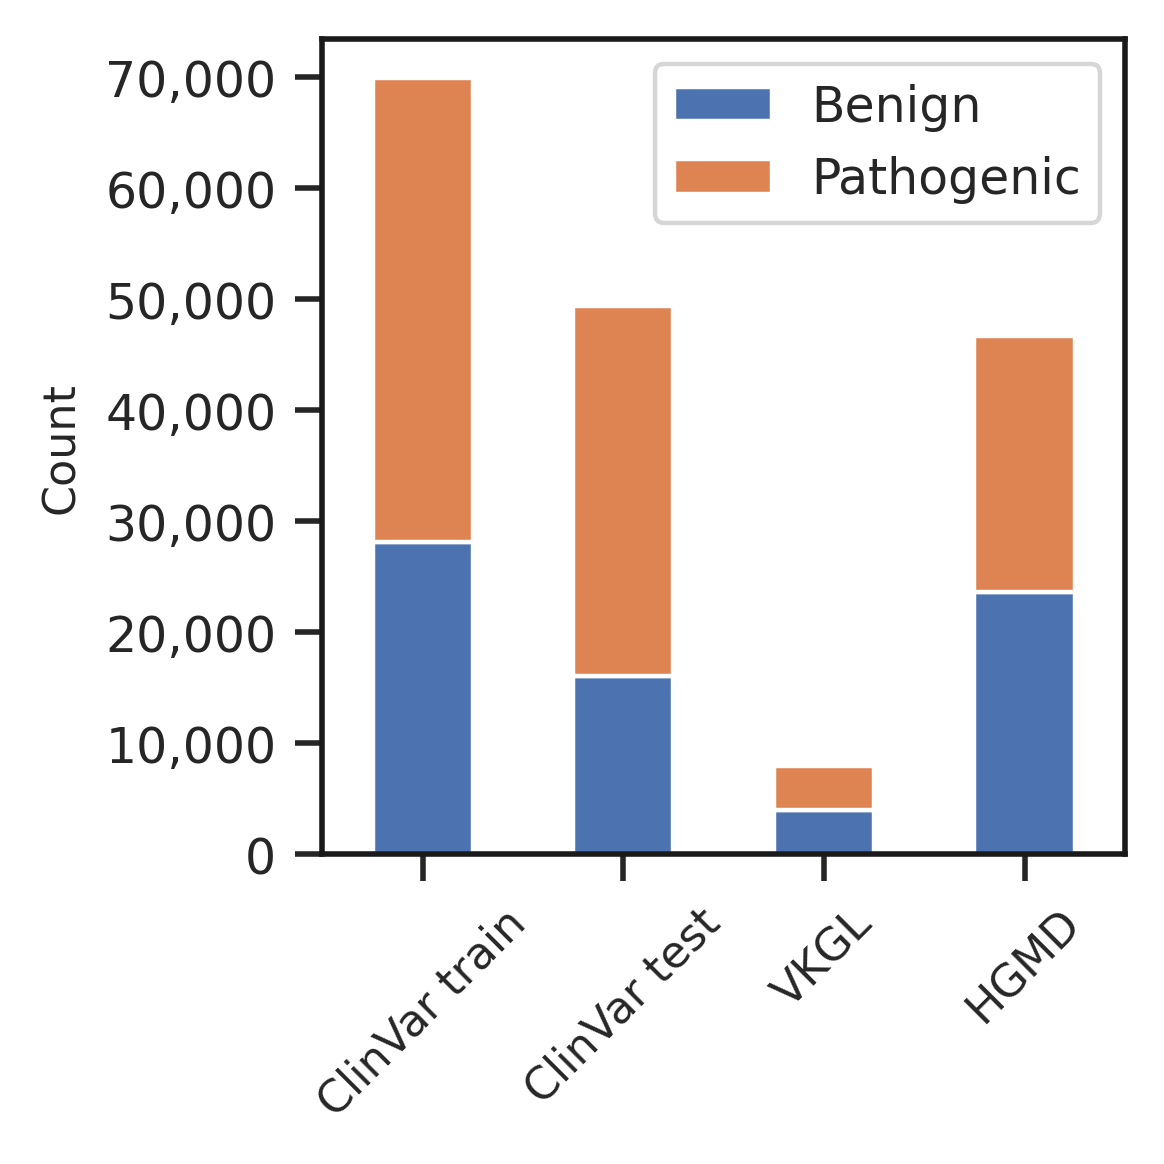

In [19]:
series_names = ['ClinVar train', 'ClinVar test', 'VKGL', 'HGMD']
series_list = [train_y, ClinVar['tag'], VKGL['tag'], HGMD['tag']]

# 获取每个series中0和1的数量
zeros = []
ones = []

for series in series_list:
    counts = series.value_counts()
    zeros.append(counts.get(0, 0))
    ones.append(counts.get(1, 0))

# 创建一个数据框来容纳这些数据
df = pd.DataFrame({'Benign': zeros, 'Pathogenic': ones}, index=series_names)

# 获取 Seaborn 的默认颜色调色板
colors = sns.color_palette()[:2]  

# 使用Pandas绘制堆叠柱状图，同时设置颜色
ax = df.plot(kind='bar', stacked=True, figsize=(3, 3), color=colors)

# 设置标签、标题和图例
ax.set_ylabel('Count', fontsize=8)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.xticks(rotation=45, fontsize=8)
ax.legend()

plt.tight_layout()
plt.savefig(f"../final_fig/pathogenic_loci_counts_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()


In [22]:
df.to_csv(f"../table/pathogenic_loci_counts_{loca}.csv")

# 多指标性能比较

In [1]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)

    optimal_threshold = threshold[np.argmax(tpr - fpr)]

    return optimal_threshold


def plot_radar_chart(metrics_list, labels, dataset_names, dataset2):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
    for metrics, name in zip(metrics_list, dataset_names):
        metrics += metrics[:1]
        ax.plot(angles, metrics, linewidth=2, label=name)
        ax.fill(angles, metrics, alpha=0.25)

    ax.set_yticklabels([])
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)
    ax.set_xticks(angles)
    ax.set_xticklabels(labels + [labels[0]])
    ax.set_title(f'{dataset2}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

    plt.tight_layout()
    plt.savefig(f'../final_fig/{dataset2}_radar_{loca}.pdf', format="pdf", dpi=1000, bbox_inches='tight')
    plt.show()



def plot_auc_curve(fpr_list, tpr_list, auc_values, dataset_names, dataset2):
    fig, ax = plt.subplots(figsize=(4, 4))
    for fpr, tpr, auc_value, name in zip(fpr_list, tpr_list, auc_values, dataset_names):
        ax.plot(fpr, tpr, label=f'{name} - AUROC = {auc_value:.3f}')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{dataset2}')
    ax.legend()
    plt.savefig(f'../final_fig/{dataset2}_auc_{loca}.pdf', format="pdf", dpi=1000, bbox_inches='tight')
    plt.show()

    
    
def plot_aupr_curve(precision_list, recall_list, aupr_values, dataset_names, dataset2):
    fig, ax = plt.subplots(figsize=(4, 4))
    for precision, recall, aupr_value, name in zip(precision_list, recall_list, aupr_values, dataset_names):
        ax.plot(recall, precision, label=f'{name} - AUPR = {aupr_value:.3f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{dataset2}')
    ax.legend()
    plt.savefig(f'../final_fig/{dataset2}_aupr_{loca}.pdf', format="pdf", dpi=1000, bbox_inches='tight')
    plt.show()



In [13]:
def compute_metrics(real_labels, scores, cut_off=0.5, n_splits=20, test_size=0.2):
    scores = pd.to_numeric(scores, errors='coerce')
    metrics_results = {
        'MCC': [], 'CKS': [], 'F1': [], 'BA': [],
        'AUPR': [], 'AUROC': []
    }

    def calculate_metrics(y_true, y_scores):
        y_pred = (y_scores > cut_off).astype('int')
        PRE, RECALL, _ = precision_recall_curve(y_true, y_scores)
        metrics = {
            'MCC': matthews_corrcoef(y_true, y_pred),
            'CKS': cohen_kappa_score(y_true, y_pred),
            'F1': f1_score(y_true, y_pred),
            'BA': balanced_accuracy_score(y_true, y_pred),
            'AUPR': auc(RECALL, PRE),
            'AUROC': auc(*roc_curve(y_true, y_scores)[:2])
        }
        for metric, value in metrics.items():
            metrics_results[metric].append(value)
    
    calculate_metrics(real_labels, scores)

    if n_splits > 1:
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
        for train_index, _ in sss.split(scores, real_labels):
            y_true, y_scores = real_labels.iloc[train_index], scores.iloc[train_index]
            calculate_metrics(y_true, y_scores)
            
    return metrics_results




def score_all(datasets, dataset2):
    results = []
    metrics_summary = {metric: [] for metric in ['MCC', 'CKS', 'F1', 'BA', 'AUPR', 'AUROC']}
    metrics_list = []

    for real_lab, score, cut_off, name in datasets:
        metrics = compute_metrics(real_lab, score, cut_off, n_splits=20, test_size=0.2)
        results.append(metrics)
        for metric in metrics:
            metrics_summary[metric].append({
                'median': np.median(metrics[metric]),
                'std': np.std(metrics[metric])
            })
        metrics_list.append([np.median(metrics[metric]) for metric in metrics])

    labels = list(metrics_summary.keys())
    dataset_names = [dataset[3] for dataset in datasets]
    
    
    plot_radar_chart(metrics_list, labels, dataset_names, dataset2)
    # plot_auc_curve(fpr_list, tpr_list, auc_values, dataset_names, dataset2)
    # plot_aupr_curve(precision_list, recall_list, aupr_values, dataset_names, dataset2)

    df = pd.DataFrame(metrics_summary, index=dataset_names).applymap(lambda x: f"{x['median']:.3f} ± {x['std']:.3f}")
    return df


In [17]:
dataset = "HGMD"
# MetaRNN = load_data(f"../final_intermediate_file/MetaRNN_{dataset}_score_2023-10-12.pkl")
# CADD = load_data(f"../final_intermediate_file/CADD_{dataset}_score_2023-10-12.pkl")
# VEST = load_data(f"../final_intermediate_file/VEST_{dataset}_score_2023-10-12.pkl")
# CAPICE = load_data(f"../final_intermediate_file/CAPICE_{dataset}_score_2023-10-12.pkl")
INDELpred = load_data(f"INDELpred_{dataset}_score_2024-01-12.pkl")

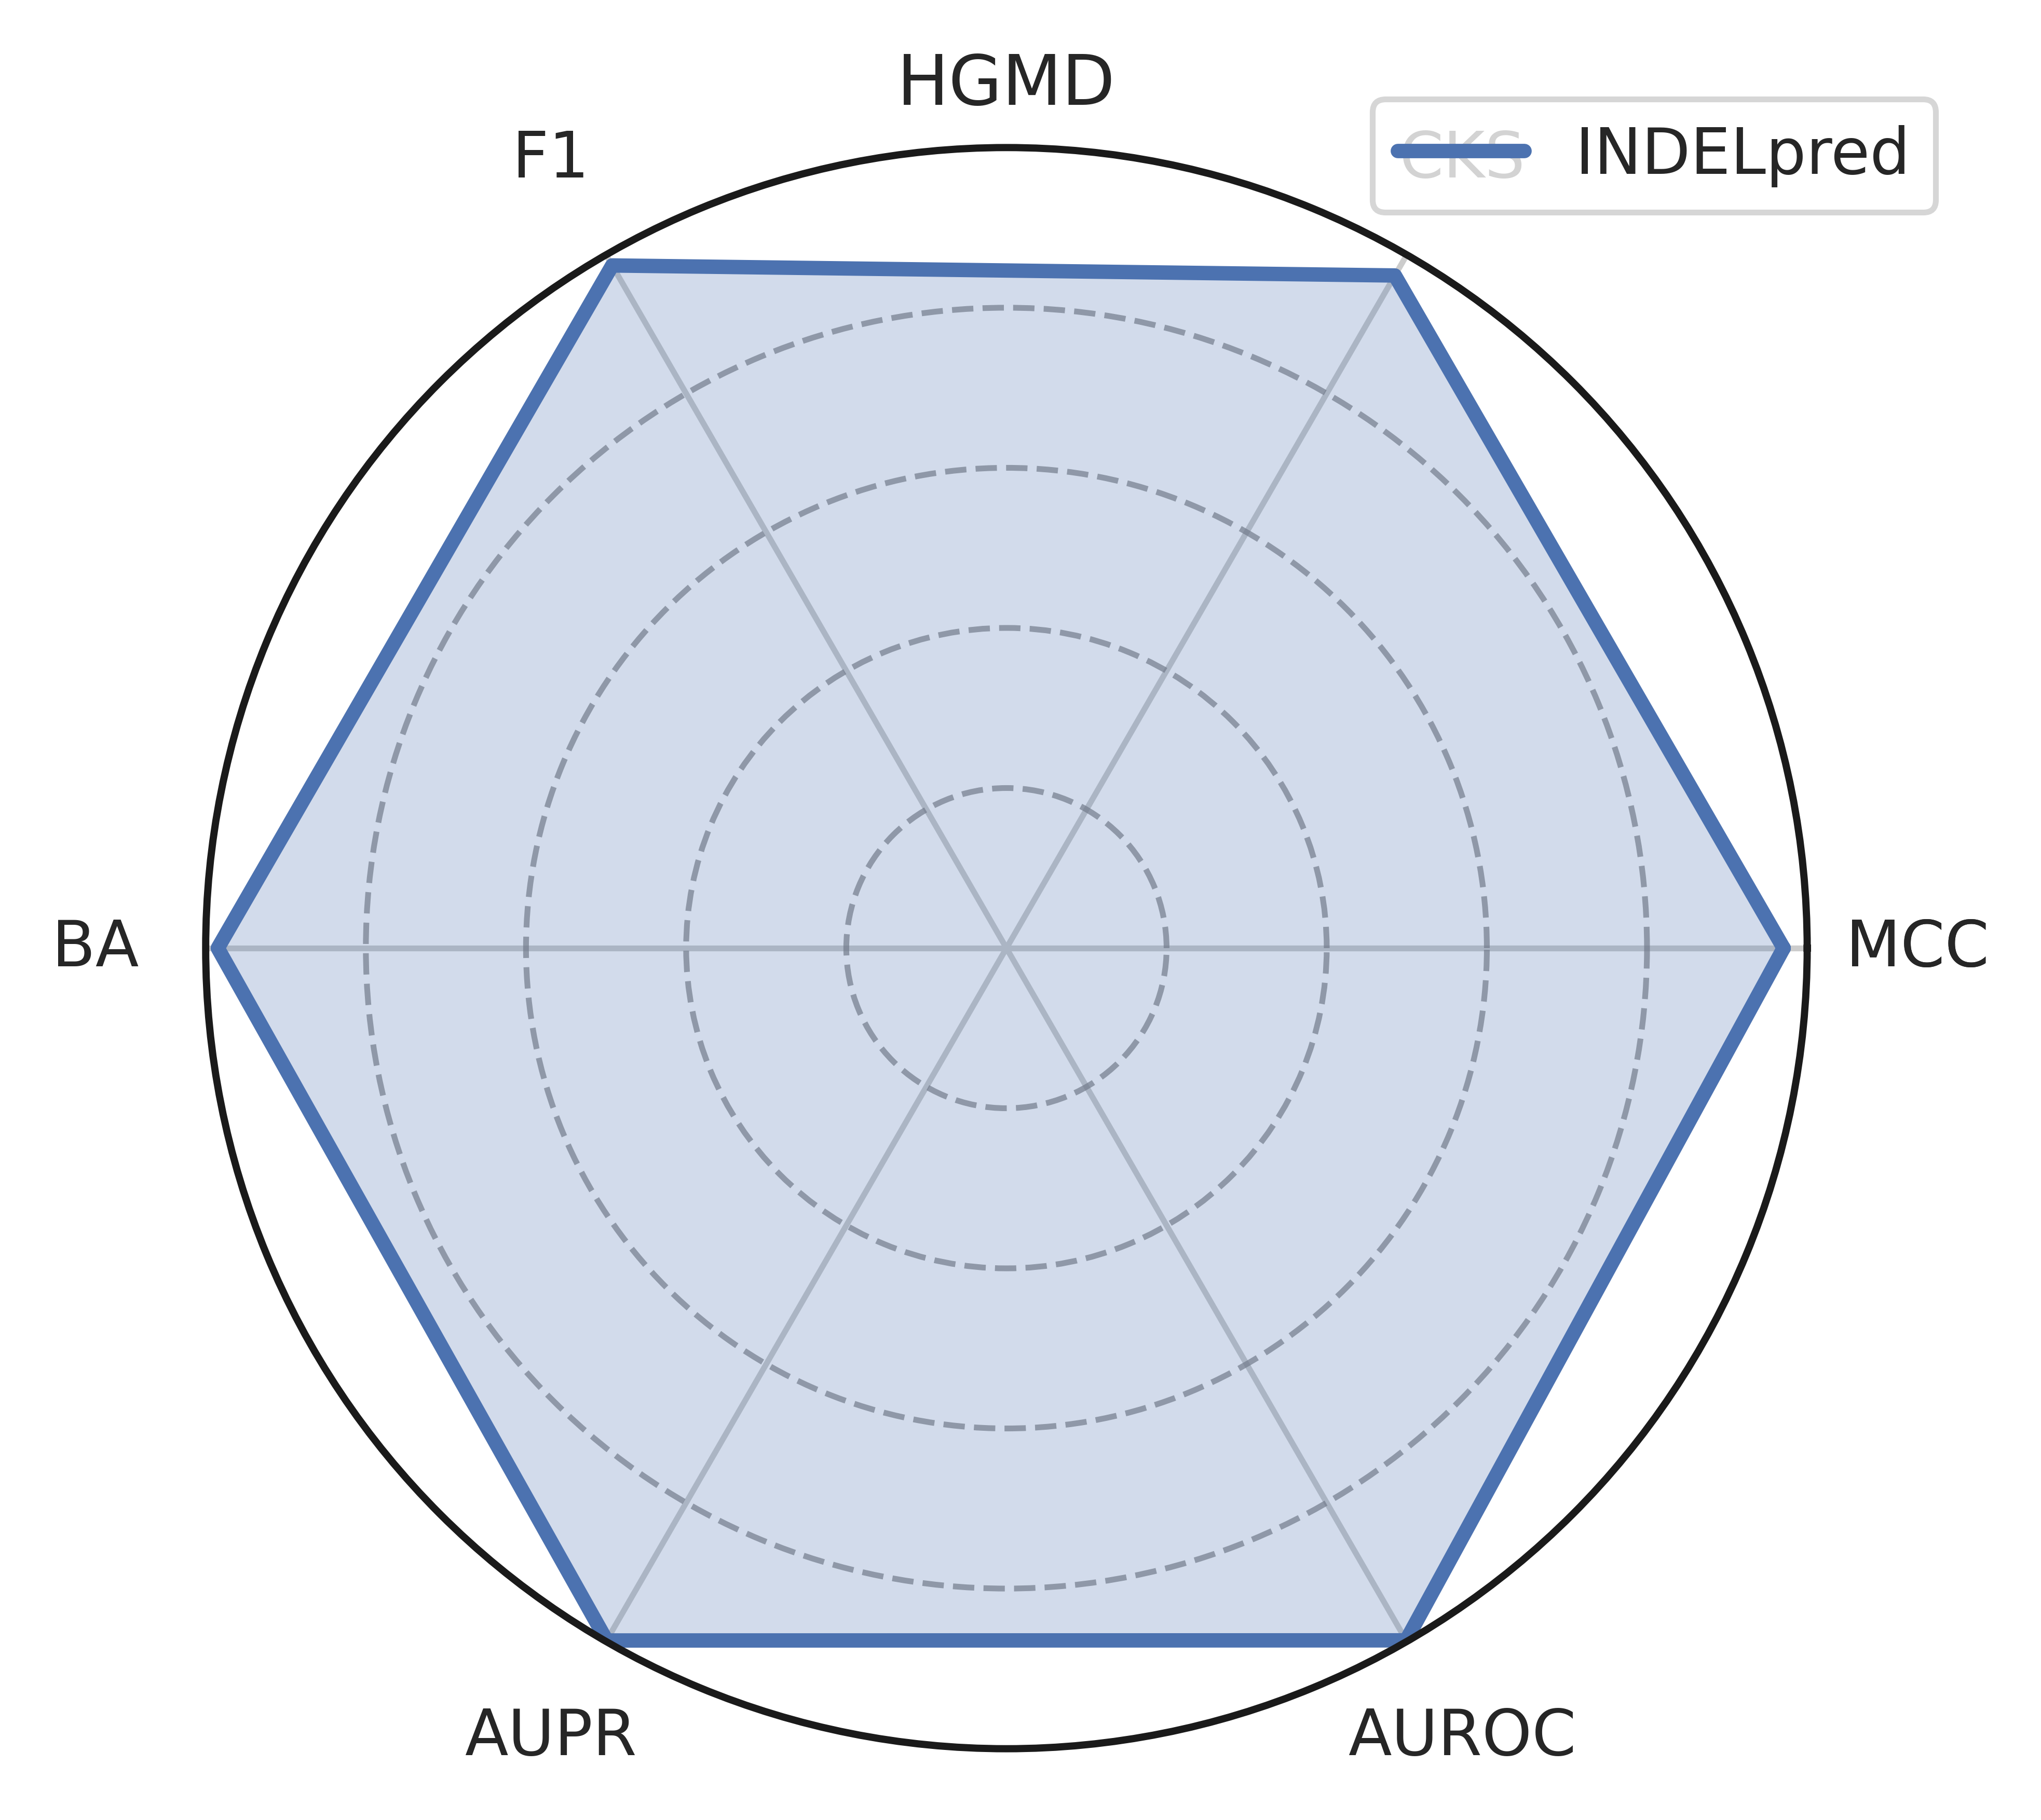

,MCC,CKS,F1,BA,AUPR,AUROC
INDELpred,0.971 ± 0.000,0.970 ± 0.000,0.985 ± 0.000,0.985 ± 0.000,0.999 ± 0.000,0.998 ± 0.000


In [18]:
# cut_off = Find_Optimal_Cutoff(y_test1, y_test_pred_prob)
methods = [(INDELpred.loc[:, 'tag'], INDELpred.loc[:, 'INDELpred score'], 0.5, 'INDELpred'),]
            # (CAPICE.loc[:, 'tag'], CAPICE.loc[:, 'score'], 0.5, 'CAPICE'),
            # (CADD.loc[:, 'tag'], CADD.loc[:, 'PHRED'], 20, 'CADD'),
            # (VEST.loc[:, 'tag'], VEST.loc[:, 'VEST score'], 0.5, 'VEST'),
            # (MetaRNN.loc[:, 'tag'], MetaRNN.loc[:, 'MetaRNN-indel_score'], 0.5, 'MetaRNN')]

metrics = score_all(methods, dataset)
# metrics.to_csv(f"../table/metrics_{dataset}_{loca}.csv", index=None)
metrics


# AUC稳定性

In [5]:
datasets = ["ClinVar", "VKGL", "HGMD","HGMDsg"]
methods = ["MetaRNN", "CADD", "VEST", "CAPICE", "INDELpred"]

data = {}

for ds in datasets:
    data[ds] = {}
    for method in methods:
        data[ds][method] = load_data(f"../final_intermediate_file/{method}_{ds}_score_2023-10-12.pkl")


In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

datasets = ["ClinVar", "VKGL", "HGMD"]
methods_cols = {
    'INDELpred': 'INDELpred score',
    'CAPICE': 'score',
    'CADD': 'PHRED',
    'VEST': 'VEST score',
    'MetaRNN': 'MetaRNN-indel_score'
}

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2)

auc_data = []

for ds in datasets:
    for method, score_col in methods_cols.items():
        df = data[ds][method]
        for train_index, _ in sss.split(df, df['tag']):
            sample_df = df.iloc[train_index]
            auc_val = roc_auc_score(sample_df['tag'], sample_df[score_col])
            auc_data.append({
                "dataset": ds,
                "method": method,
                "auc": auc_val
            })

auc_df = pd.DataFrame(auc_data)

In [63]:
auc_df

,dataset,method,auc
0,ClinVar,INDELpred,0.992850
1,ClinVar,INDELpred,0.992500
2,ClinVar,INDELpred,0.992717
3,ClinVar,INDELpred,0.992705
4,ClinVar,INDELpred,0.992718
...,...,...,...
295,HGMD,MetaRNN,0.894445
296,HGMD,MetaRNN,0.897829
297,HGMD,MetaRNN,0.881991
298,HGMD,MetaRNN,0.877931


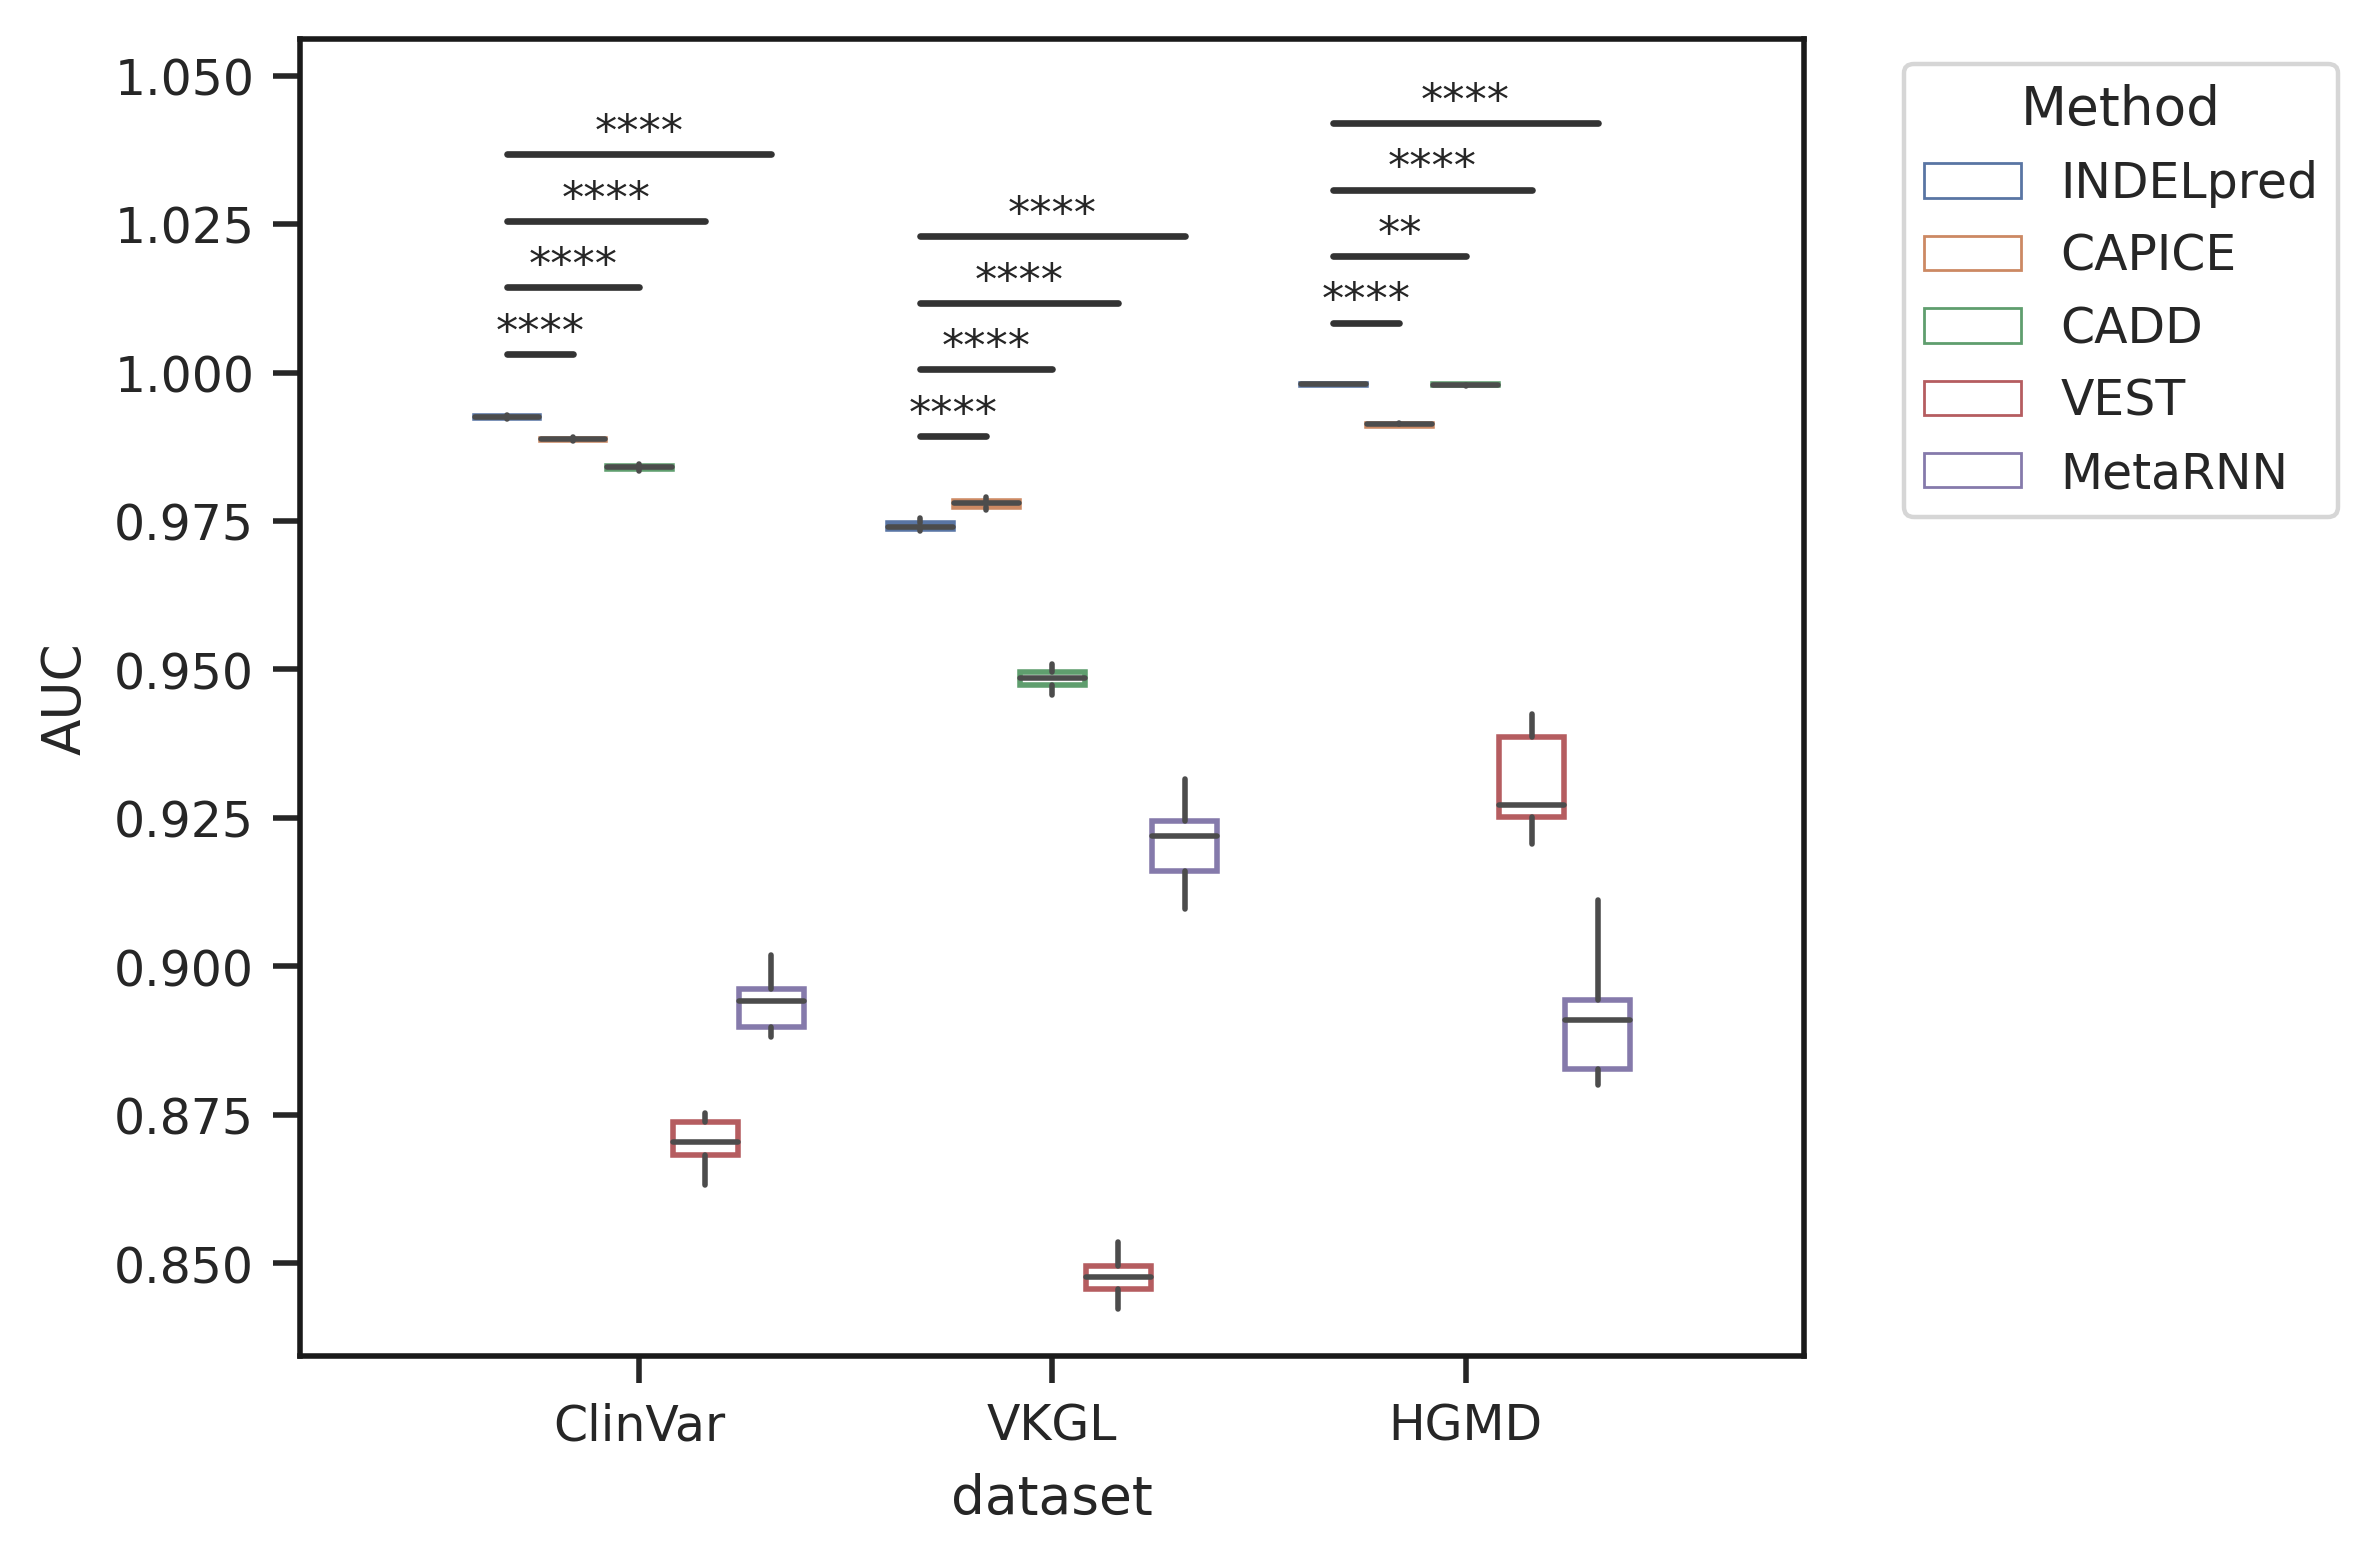

In [94]:
# Plotting
plt.figure(figsize=(6, 4))
sns_boxplot = sns.boxplot(data=auc_df, x="dataset", y="auc", hue="method", showfliers=False, showcaps=False, linewidth=1, width=0.8)
plt.ylabel("AUC")
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Extract the different parts of the boxplot
boxes = [box for box in sns_boxplot.patches]
whiskers = [whisker for whisker in sns_boxplot.lines]

# Change box border color to match fill color
for box in boxes:
    col = box.get_facecolor()
    box.set_edgecolor(col)
    box.set_facecolor('None')

# Change whisker, cap and median colors
for whisker in whiskers:
    col = whisker.get_color()
    whisker.set_color(col)

for legpatch in sns_boxplot.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')


from statannotations.Annotator import Annotator
pairs=[
       (('ClinVar', "INDELpred"), ("ClinVar", "CAPICE")),
       (('ClinVar', "INDELpred"), ("ClinVar", "CADD")),
       (('ClinVar', "INDELpred"), ("ClinVar", "VEST")),
       (('ClinVar', "INDELpred"), ("ClinVar", "MetaRNN")),


       (('VKGL', "INDELpred"), ("VKGL", "CAPICE")),
       (('VKGL', "INDELpred"), ("VKGL", "CADD")),
       (('VKGL', "INDELpred"), ("VKGL", "VEST")),
       (('VKGL', "INDELpred"), ("VKGL", "MetaRNN")),

       (('HGMD', "INDELpred"), ("HGMD", "CAPICE")),
       (('HGMD', "INDELpred"), ("HGMD", "CADD")),
       (('HGMD', "INDELpred"), ("HGMD", "VEST")),
       (('HGMD', "INDELpred"), ("HGMD", "MetaRNN")),
]
annotator=Annotator(ax=sns_boxplot, pairs=pairs,x="dataset", y="auc", hue="method",data=auc_df)
annotator.configure(test='Mann-Whitney', text_format='star',
                   verbose=False,line_width=1.2,fontsize=8,line_height=0, 
                    text_offset=0,line_offset=0)
annotator.new_plot(sns_boxplot,pairs=pairs,x="dataset", y="auc", hue="method",data=auc_df)
annotator.apply_and_annotate()


plt.savefig(f'../final_fig/stability_of_methods_{loca}.pdf', format="pdf", dpi=1000, bbox_inches='tight')
plt.show()

# 0-1分布

In [20]:
from joypy import joyplot


In [23]:
dataset = "ClinVar"
INDELpred = data[dataset]['INDELpred']
CAPICE = data[dataset]['CAPICE']
CADD = data[dataset]['CADD']
VEST = data[dataset]['VEST']
MetaRNN = data[dataset]['MetaRNN']

methods = [(INDELpred.loc[:, 'tag'], INDELpred.loc[:, 'INDELpred score'], 0.5, 'INDELpred'),
            (CAPICE.loc[:, 'tag'], CAPICE.loc[:, 'score'], 0.5, 'CAPICE'),
            (CADD.loc[:, 'tag'], CADD.loc[:, 'PHRED'], 20, 'CADD'),
            (VEST.loc[:, 'tag'], VEST.loc[:, 'VEST score'], 0.5, 'VEST'),
            (MetaRNN.loc[:, 'tag'], MetaRNN.loc[:, 'MetaRNN-indel_score'], 0.5, 'MetaRNN')]

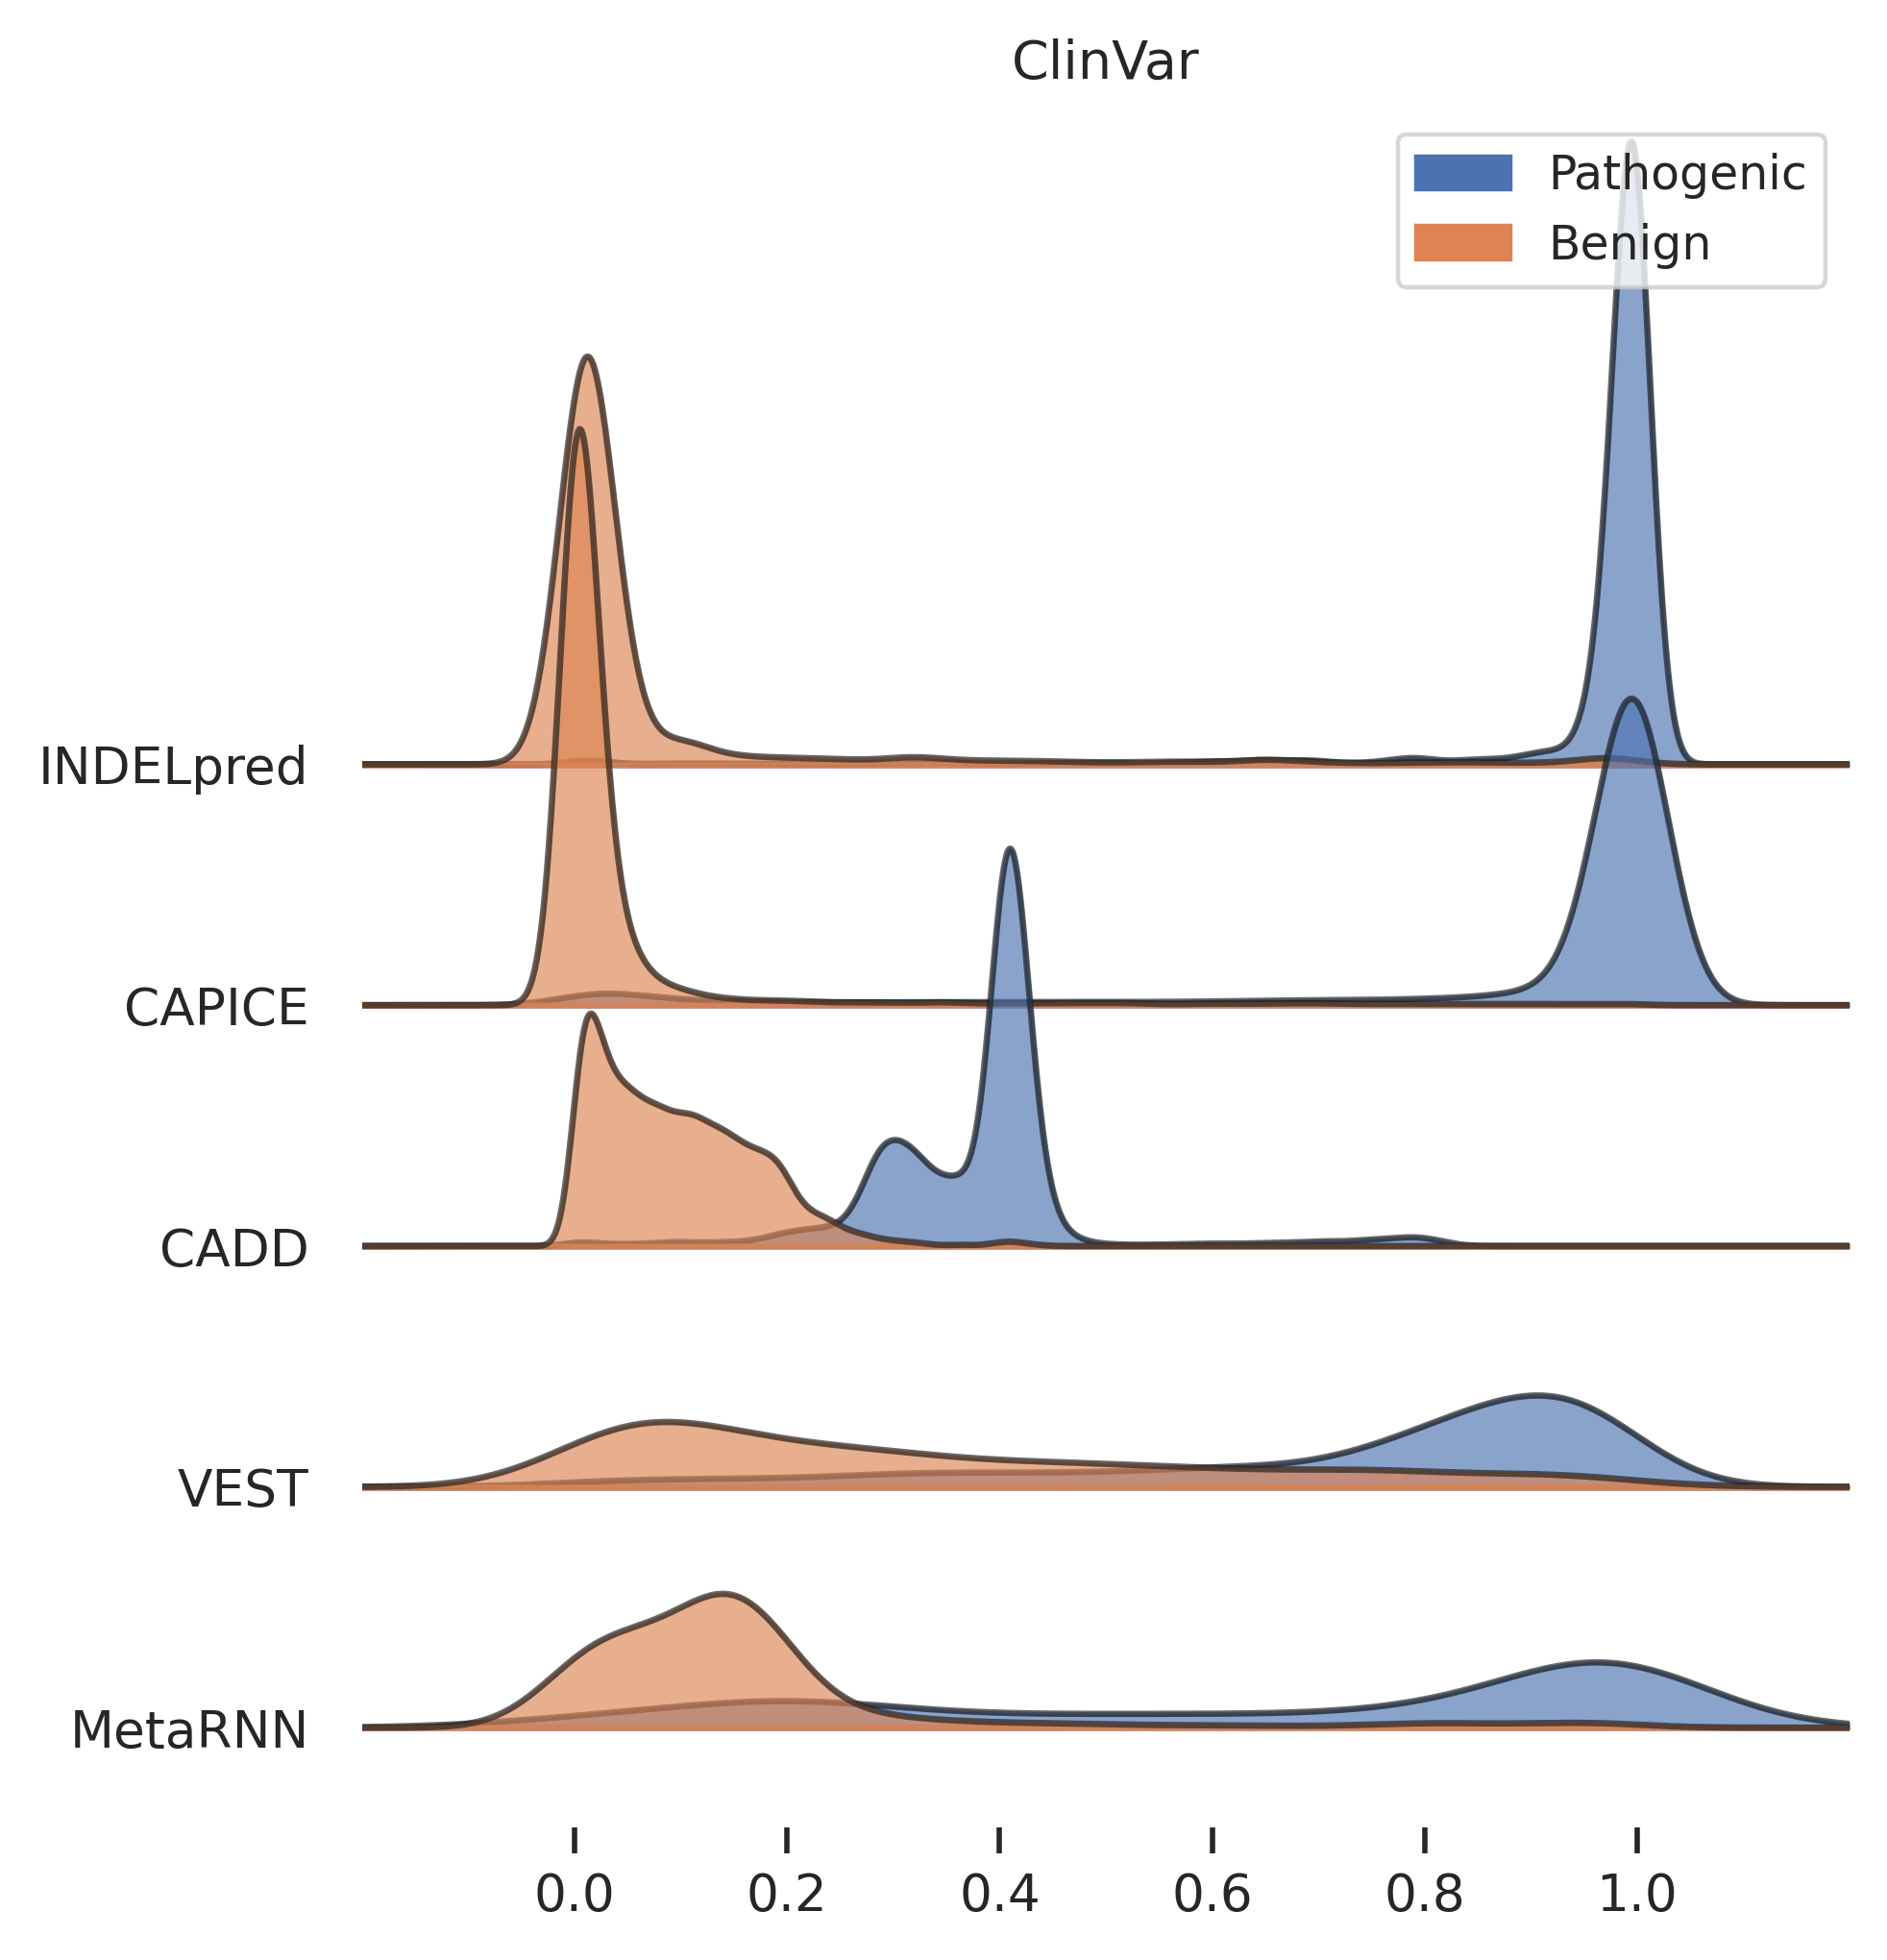

In [24]:
method_order = ['INDELpred', 'CAPICE', 'CADD', 'VEST', 'MetaRNN']
def scale_cadd_values(value):
    return (value / 20) * 0.5

data_list = []

for method in methods:
    y_test, y_test_pred_prob, threshold, tools = method
    
    if tools == "CADD":
        y_test_pred_prob = y_test_pred_prob.apply(scale_cadd_values)
        y_test_pred_prob = y_test_pred_prob[y_test_pred_prob <= 1]
        
    positive_data = y_test_pred_prob[y_test == 1].tolist()
    negative_data = y_test_pred_prob[y_test == 0].tolist()

    for pos, neg in zip(positive_data, negative_data):
        data_list.append({'Method': tools, 'Pathogenic': pos, 'Benign': neg})

df = pd.DataFrame(data_list)
df['Pathogenic'] = pd.to_numeric(df['Pathogenic'], errors='coerce')
df['Benign'] = pd.to_numeric(df['Benign'], errors='coerce')
df['Method'] = pd.Categorical(df['Method'], categories=method_order, ordered=True)

fig, axes = joyplot(
    df,
    by="Method",
    column=["Pathogenic", "Benign"],
    overlap=2,
    legend=True,
    alpha=0.65,
    figsize=(5, len(methods) * 1),
)
plt.title(f'{dataset}', fontsize=10)
plt.savefig(f'../final_fig/{dataset}_distribution_joyplot_{loca}.pdf', format="pdf", dpi=1000, bbox_inches='tight')
plt.show()

# realworld运行时间

In [19]:
df_minutes = pd.read_table("../table/run_time.txt", index_col=0)
df_minutes = df_minutes.drop(["MetaRNN"], axis=1)
df_long = df_minutes.reset_index().melt(id_vars='index', var_name='Software', value_name='Time (minutes)')
df_long = df_long.rename(columns={'index': 'Sample'})

In [25]:
df_minutes.describe()

,CAPICE,INDELpred,CADD
count,30.000000,30.000000,27.000000
mean,271.083867,57.799900,2343.316741
std,203.709330,45.995363,1314.386664
min,65.594000,32.037000,1474.500000
25%,186.357750,35.564250,1719.620500
50%,227.944500,51.998500,1888.038000
75%,313.160750,54.797750,2812.009000
max,881.543000,256.523000,8278.709000


In [21]:
# 计算秩和检验
capice_indelpred_stat, capice_indelpred_p = mannwhitneyu(df_minutes['CAPICE'], df_minutes['INDELpred'], alternative='two-sided')
cadd_indelpred_stat, cadd_indelpred_p = mannwhitneyu(df_minutes['CADD'].dropna(), df_minutes['INDELpred'], alternative='two-sided')

capice_indelpred_stat, capice_indelpred_p, cadd_indelpred_stat, cadd_indelpred_p

(875.0, 3.4741966068317727e-10, 810.0, 1.0145734990368415e-10)

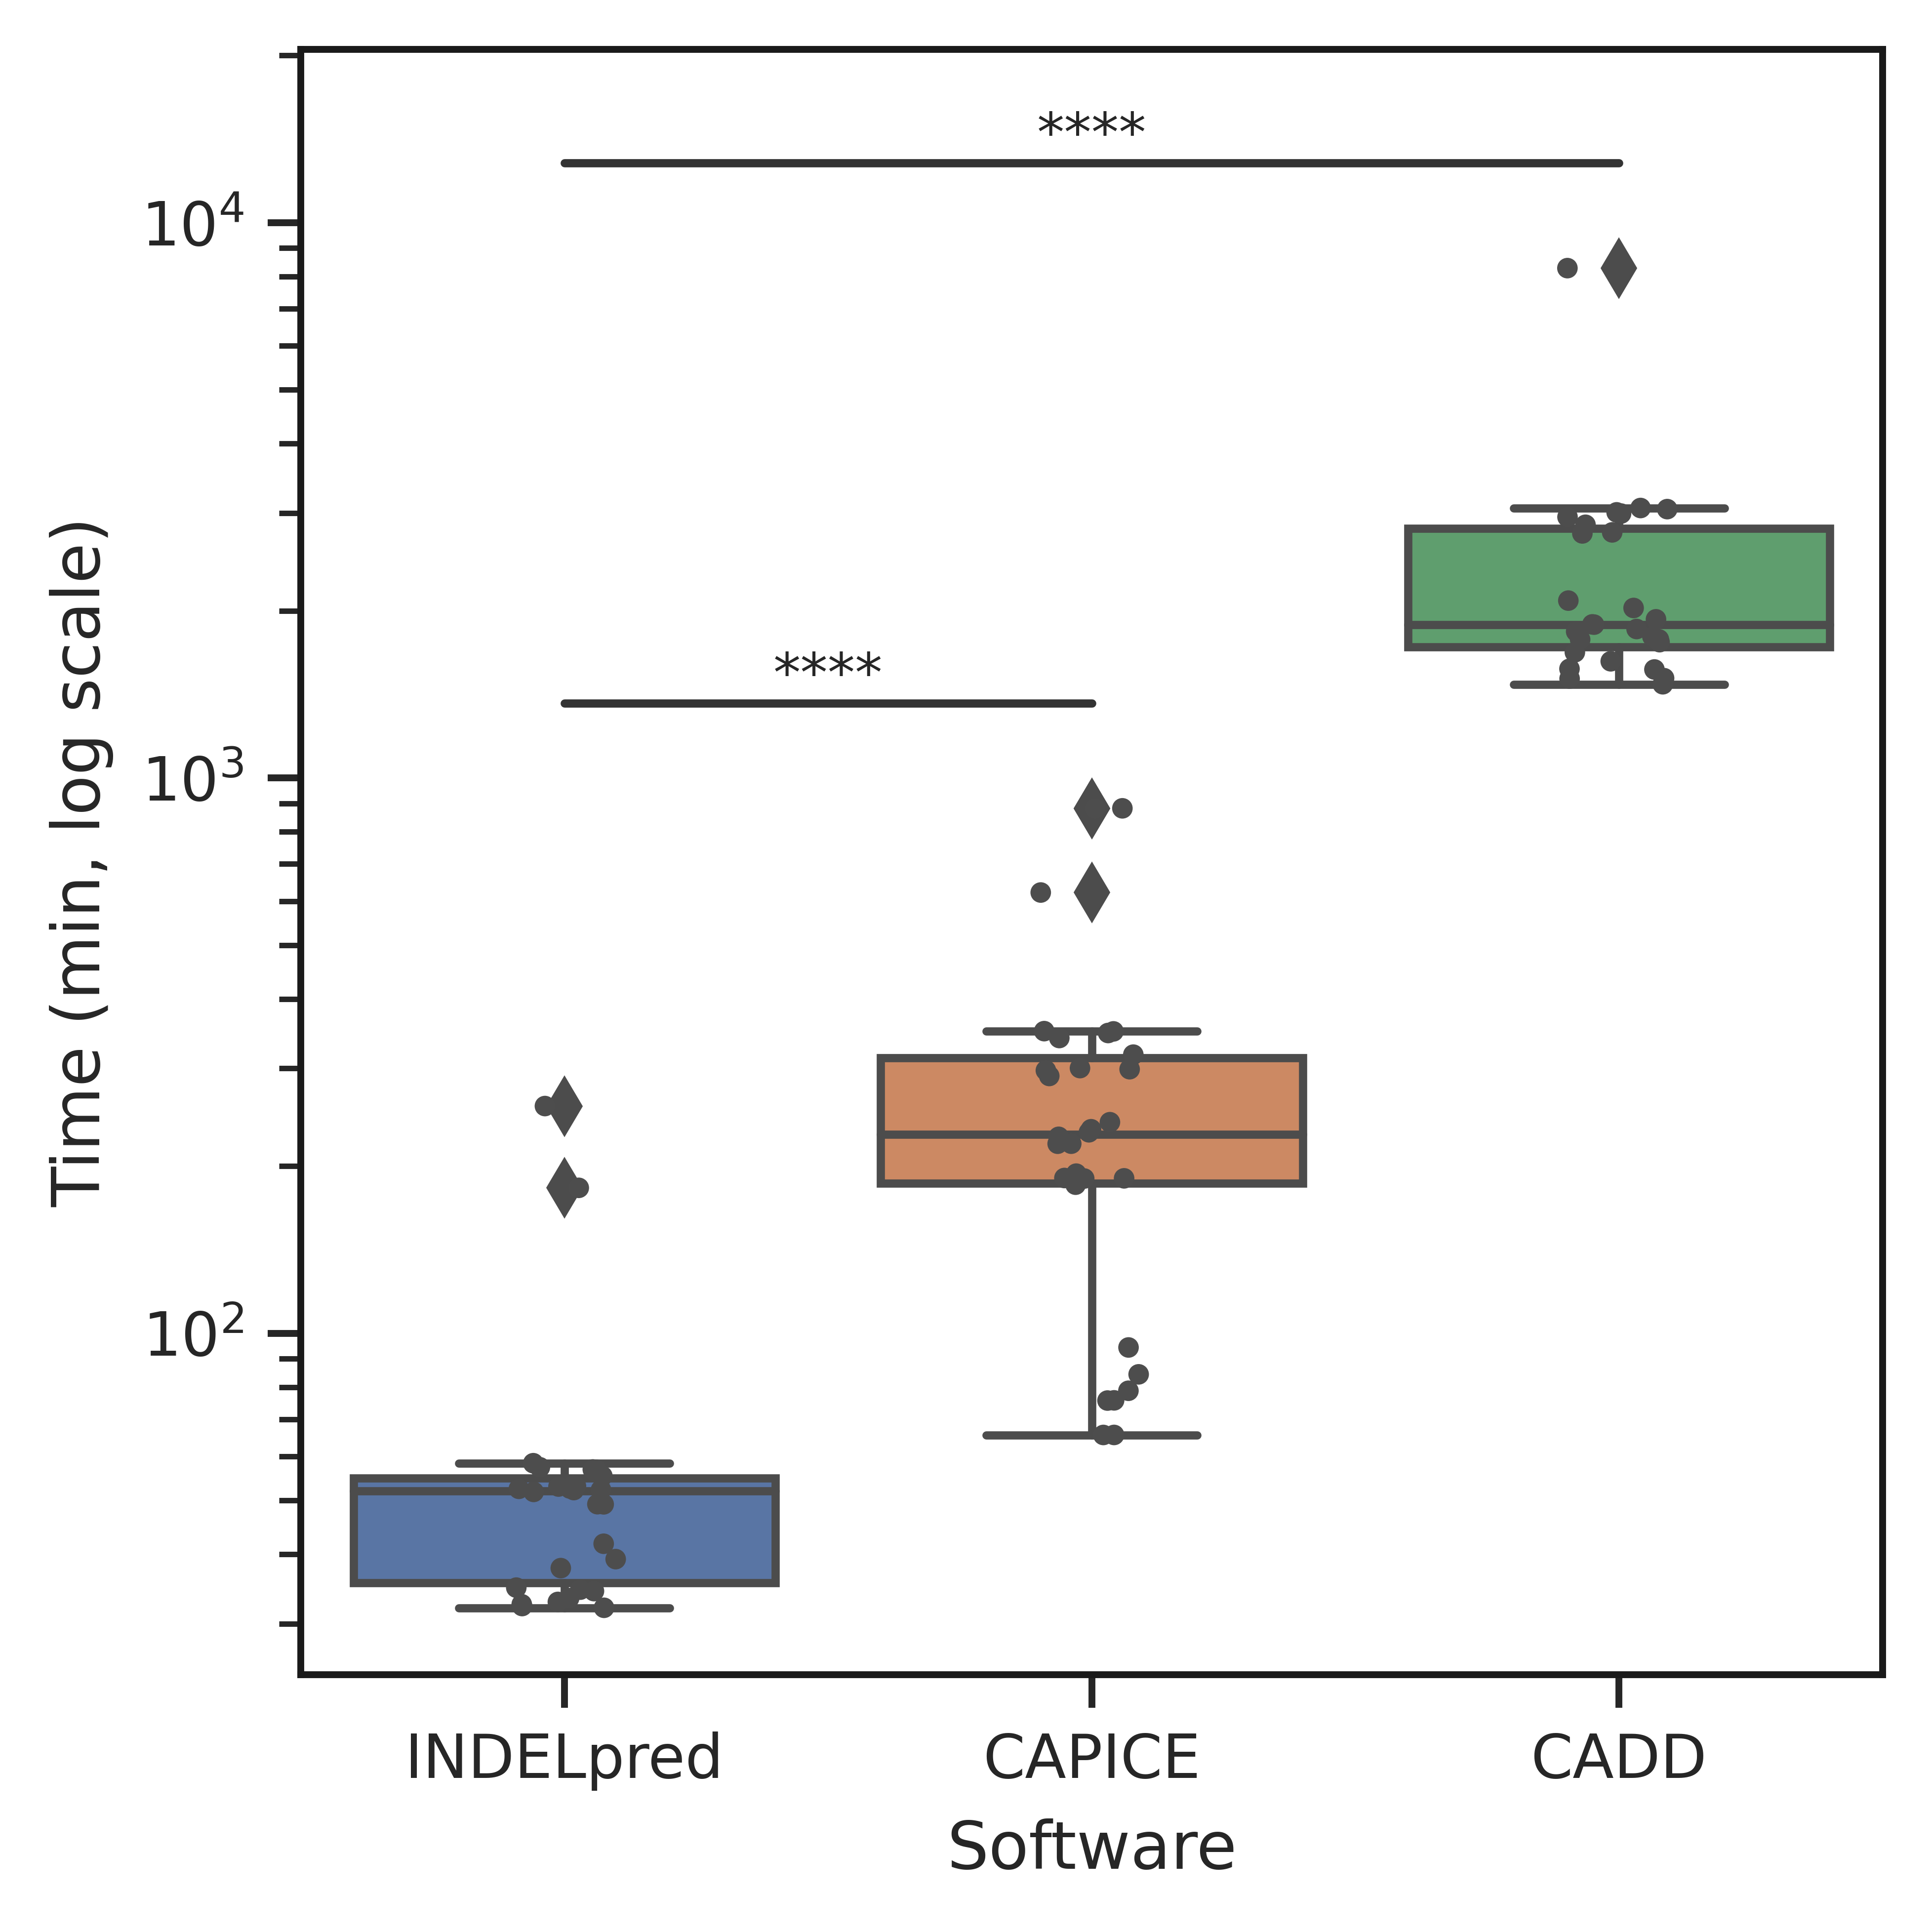

In [25]:
df_long = df_minutes.reset_index().melt(id_vars='index', var_name='Software', value_name='Time (minutes)')
df_long = df_long.rename(columns={'index': 'Sample'})
category_order = ['INDELpred', 'CAPICE', 'CADD']
df_long['Software'] = pd.Categorical(df_long['Software'], categories=category_order, ordered=True)

# Plotting the boxplot with a log scale on y-axis
plt.figure(figsize=(4, 4))
ax = sns.boxplot(x='Software', y='Time (minutes)', data=df_long, order=['INDELpred', 'CAPICE', 'CADD'])
ax = sns.stripplot(x='Software', y='Time (minutes)', data=df_long, order=['INDELpred', 'CAPICE', 'CADD'], color='.3', jitter=True, size=3, linewidth=0)
ax.set_yscale('log')
plt.ylabel('Time (min, log scale)')

from statannotations.Annotator import Annotator
pairs=[("INDELpred", "CAPICE"), ("INDELpred", "CADD")]
annotator=Annotator(ax=ax, pairs=pairs,x='Software', y='Time (minutes)',data=df_long)
annotator.configure(test='Mann-Whitney', text_format='star',
                   verbose=False,line_width=1.2,fontsize=8,line_height=0, 
                    text_offset=0,line_offset=0)
annotator.new_plot(ax,pairs=pairs,x='Software', y='Time (minutes)',data=df_long)
annotator.apply_and_annotate()

plt.tight_layout()
plt.savefig(f'../final_fig/real_world_runtime_{loca}.pdf', format="pdf", bbox_inches='tight')
plt.show()

# 数据集运行时间

In [13]:
df = pd.read_csv("../final_intermediate_file/processed_summary_time.csv")

In [14]:
order = ['ClinVar', 'VKGL', 'HGMD']
df['Dataset'] = pd.Categorical(df['Dataset'], categories=order, ordered=True)
df = df.sort_values('Dataset')

In [15]:
from scipy.stats import mannwhitneyu

software_space = {'indelpred': 30, 'cadd': 129, 'capice': 84}

# 将空间大小添加到DataFrame中
df['Space_GB'] = df['Software'].map(software_space)

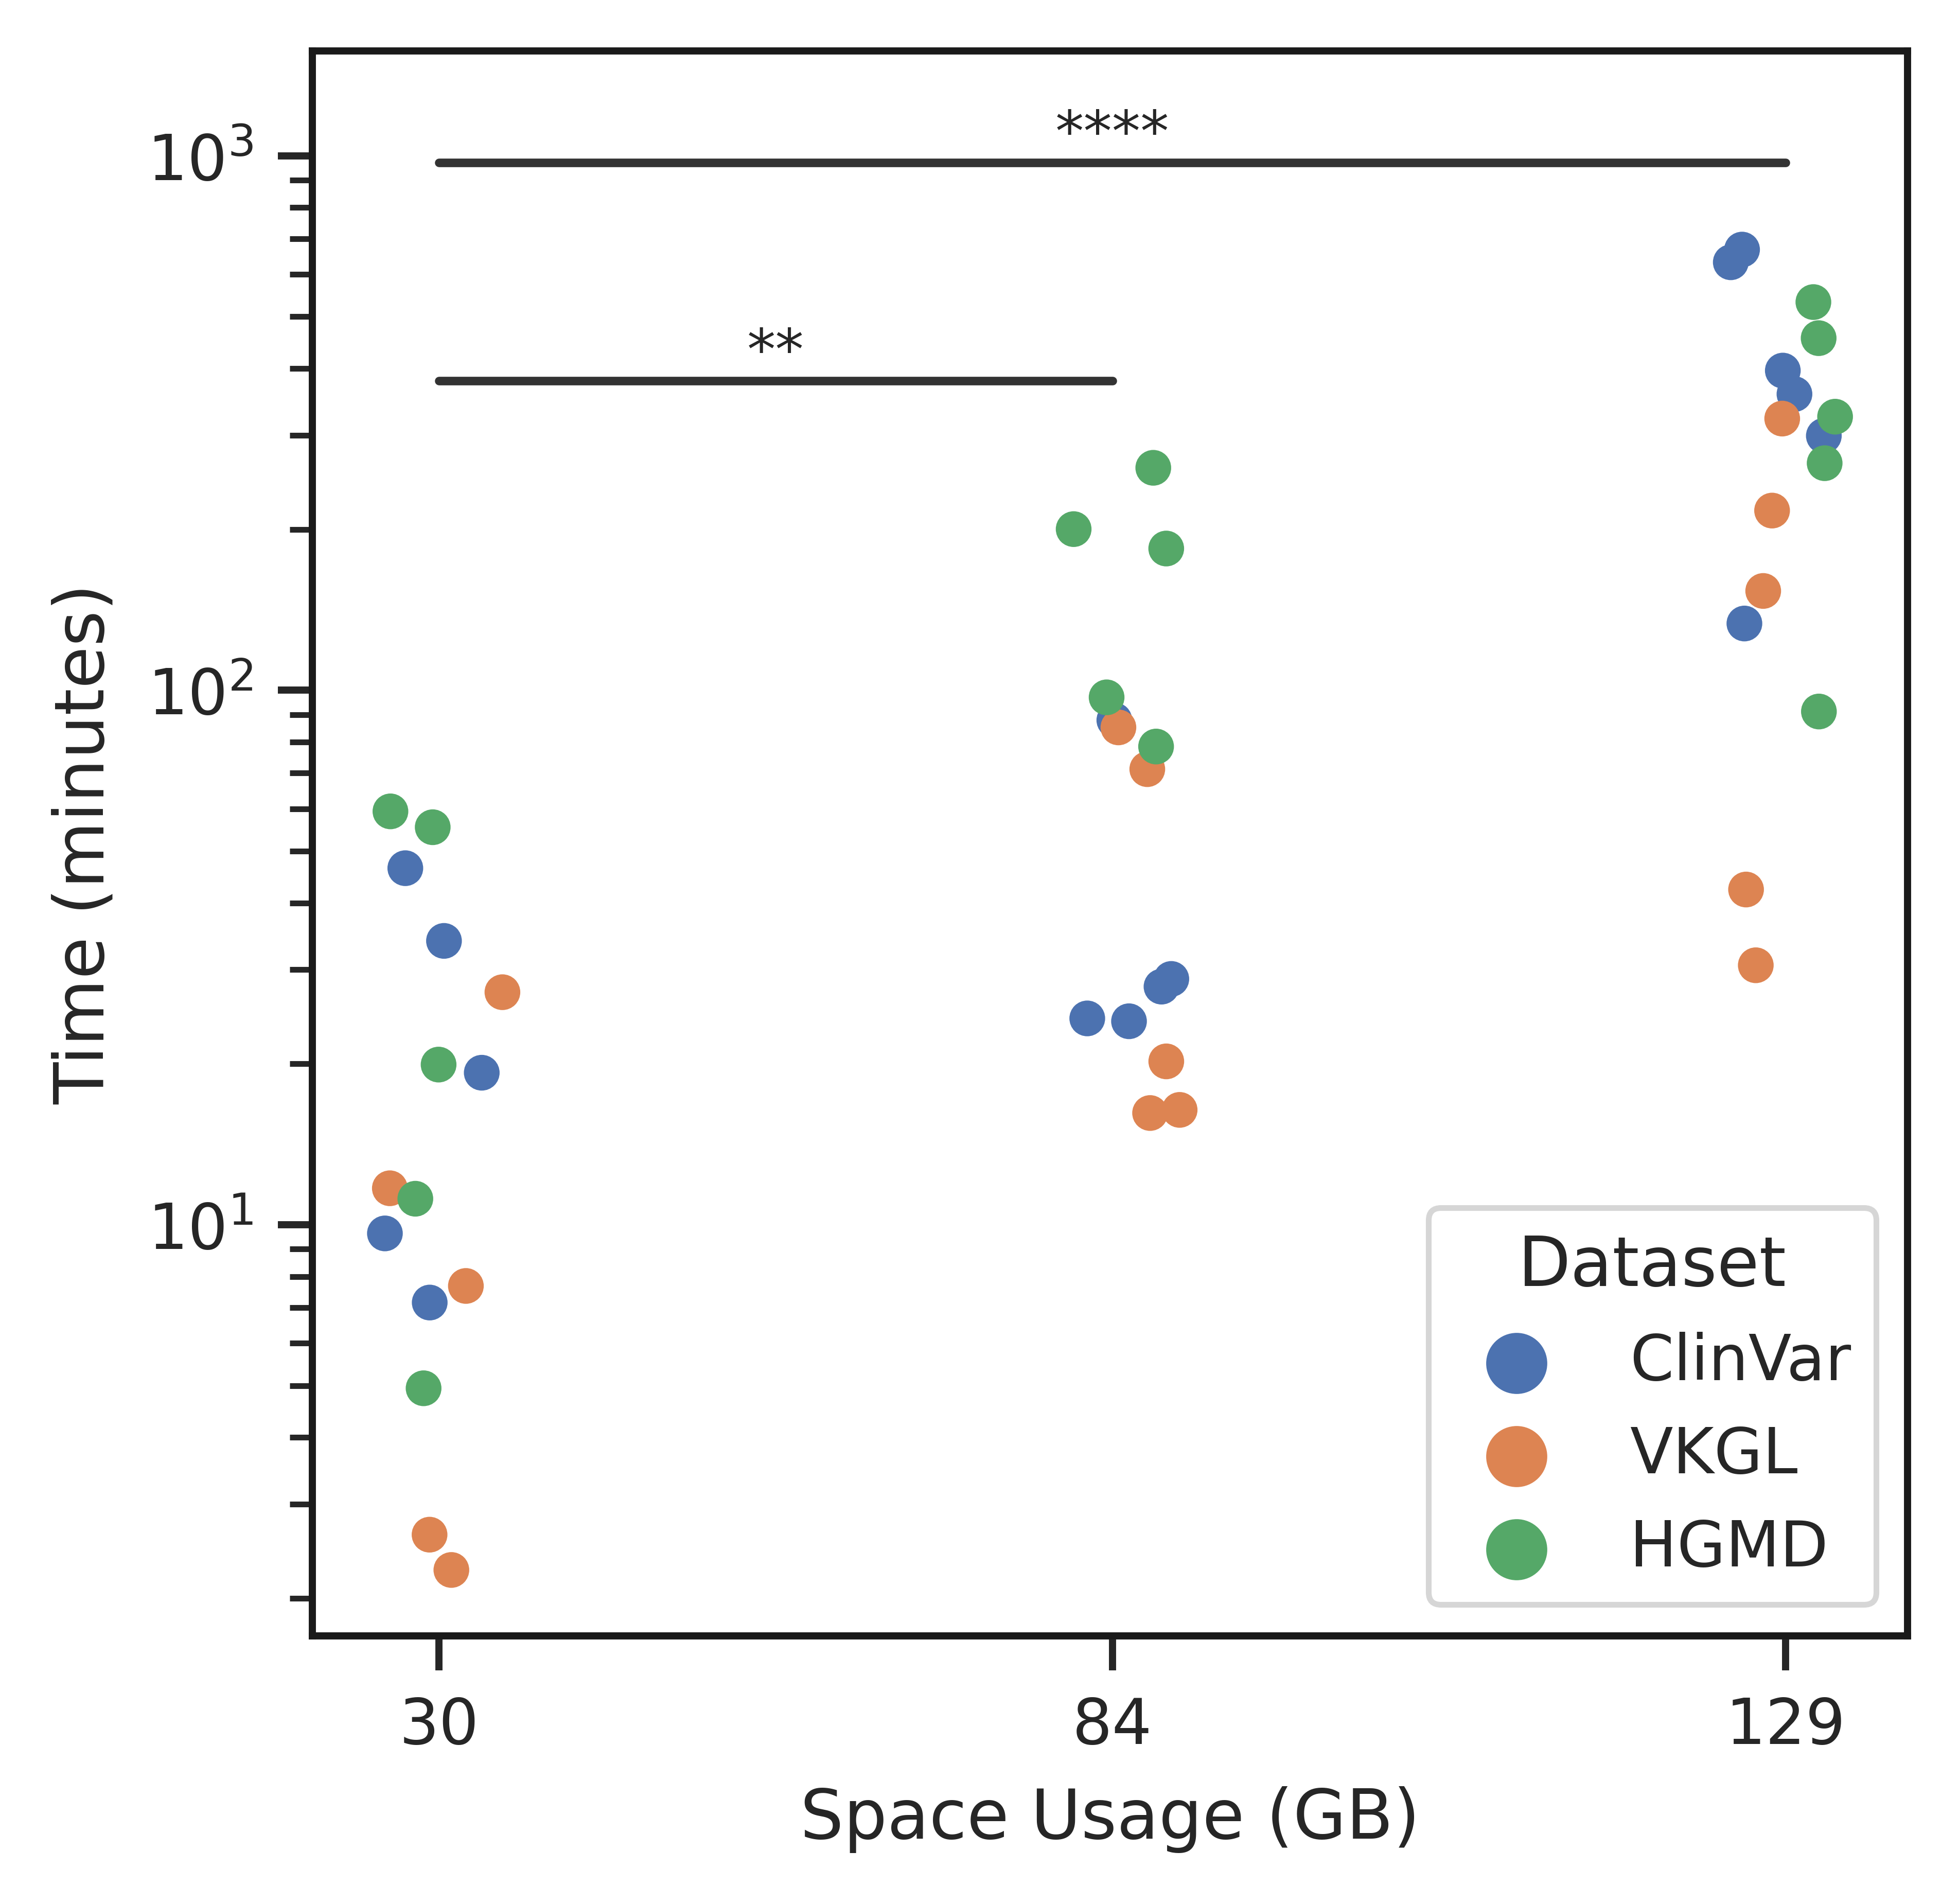

In [19]:
# 重新绘制点图，使用对数尺度的时间坐标
plt.figure(figsize=(4, 4))
# ax = sns.swarmplot(x='Space_GB', y='Time', hue='Dataset', data=df)
ax = sns.stripplot(x='Space_GB', y='Time', hue='Dataset', data=df, jitter=True)
ax.set_yscale('log')
plt.xlabel('Space Usage (GB)')
plt.ylabel('Time (minutes)')
plt.legend(title='Dataset')

from statannotations.Annotator import Annotator
pairs=[(30, 84), (30, 129)]
annotator=Annotator(ax=ax, pairs=pairs,x='Space_GB', y='Time', data=df)
annotator.configure(test='Mann-Whitney', text_format='star',
                   verbose=False,line_width=1.2,fontsize=8,line_height=0, 
                    text_offset=0,line_offset=0)
annotator.new_plot(ax,pairs=pairs,x='Space_GB', y='Time', data=df)
annotator.apply_and_annotate()

plt.savefig(f'../final_fig/dataset_runtime_p_{loca}.pdf', format="pdf", bbox_inches='tight')
plt.show()

In [16]:
# 进行秩和检验：Capice vs. IndelPred，CADD vs. IndelPred
capice_time = df[df['Software'] == 'capice']['Time']
indelpred_time = df[df['Software'] == 'indelpred']['Time']
cadd_time = df[df['Software'] == 'cadd']['Time']

# 计算秩和检验
capice_indelpred_stat, capice_indelpred_p = mannwhitneyu(capice_time, indelpred_time, alternative='two-sided')
cadd_indelpred_stat, cadd_indelpred_p = mannwhitneyu(cadd_time, indelpred_time, alternative='two-sided')

capice_indelpred_stat, capice_indelpred_p, cadd_indelpred_stat, cadd_indelpred_p

(188.0, 0.0018654646290708888, 233.0, 8.709690096995095e-06)

# real world结果

In [5]:
dataset = "real_world"
MetaRNN = load_data("../final_intermediate_file/MetaRNN_real_world_score_2023-10-12.pkl")
CADD = load_data(f"../final_intermediate_file/CADD_real_world_score_2023-10-16.pkl")
VEST = load_data("../final_intermediate_file/VEST_real_world_score_2023-10-12.pkl")
CAPICE = load_data("../final_intermediate_file/CAPICE_real_world_score_2023-10-12.pkl")
INDELpred = load_data("../final_intermediate_file/INDELpred_real_world_score_2023-10-12.pkl")

In [11]:
def prepare_df(df, score_column):
    return df.sort_values(by=[score_column, 'tag'], ascending=[False, False])

def count_tag_ones_optimized(sorted_df, n, score_column):
    top_n = sorted_df.head(n)
    count = top_n['tag'].value_counts().get(1, 0)
    condition = (
        (top_n['CHR'] == "16") &
        (top_n['POS'] == 29814384) &
        (top_n['REF'] == 'CG') &
        (top_n['ALT'] == 'C')
    )
    count += 4 * len(top_n[condition])
    return count / 30

# Prepare DataFrames
INDELpred_sorted = prepare_df(INDELpred, 'INDELpred score')
CAPICE_sorted = prepare_df(CAPICE, 'score')
CADD_sorted = prepare_df(CADD, 'PHRED')
VEST_sorted = prepare_df(VEST, 'VEST score')
MetaRNN_sorted = prepare_df(MetaRNN, 'MetaRNN-indel_score')

# Lists to hold the counts
counts_30 = []
counts_100 = []
counts_150 = []

# Labels for the tools
labels = ['INDELpred score', 'score', 'PHRED', 'VEST score', 'MetaRNN-indel_score']

# Iterate through the sorted DataFrames and the labels simultaneously
for sorted_df, label in zip([INDELpred_sorted, CAPICE_sorted, CADD_sorted, VEST_sorted, MetaRNN_sorted], labels):
    counts_30.append(count_tag_ones_optimized(sorted_df, 30, label))
    counts_100.append(count_tag_ones_optimized(sorted_df, 100, label))
    counts_150.append(count_tag_ones_optimized(sorted_df, 150, label))

In [12]:
print(counts_30,counts_100,counts_150)

[0.5666666666666667, 0.13333333333333333, 0.3333333333333333, 0.3, 0.0] [0.9, 0.4, 0.6, 0.7, 0.03333333333333333] [0.9333333333333333, 0.5333333333333333, 0.6, 0.8333333333333334, 0.03333333333333333]


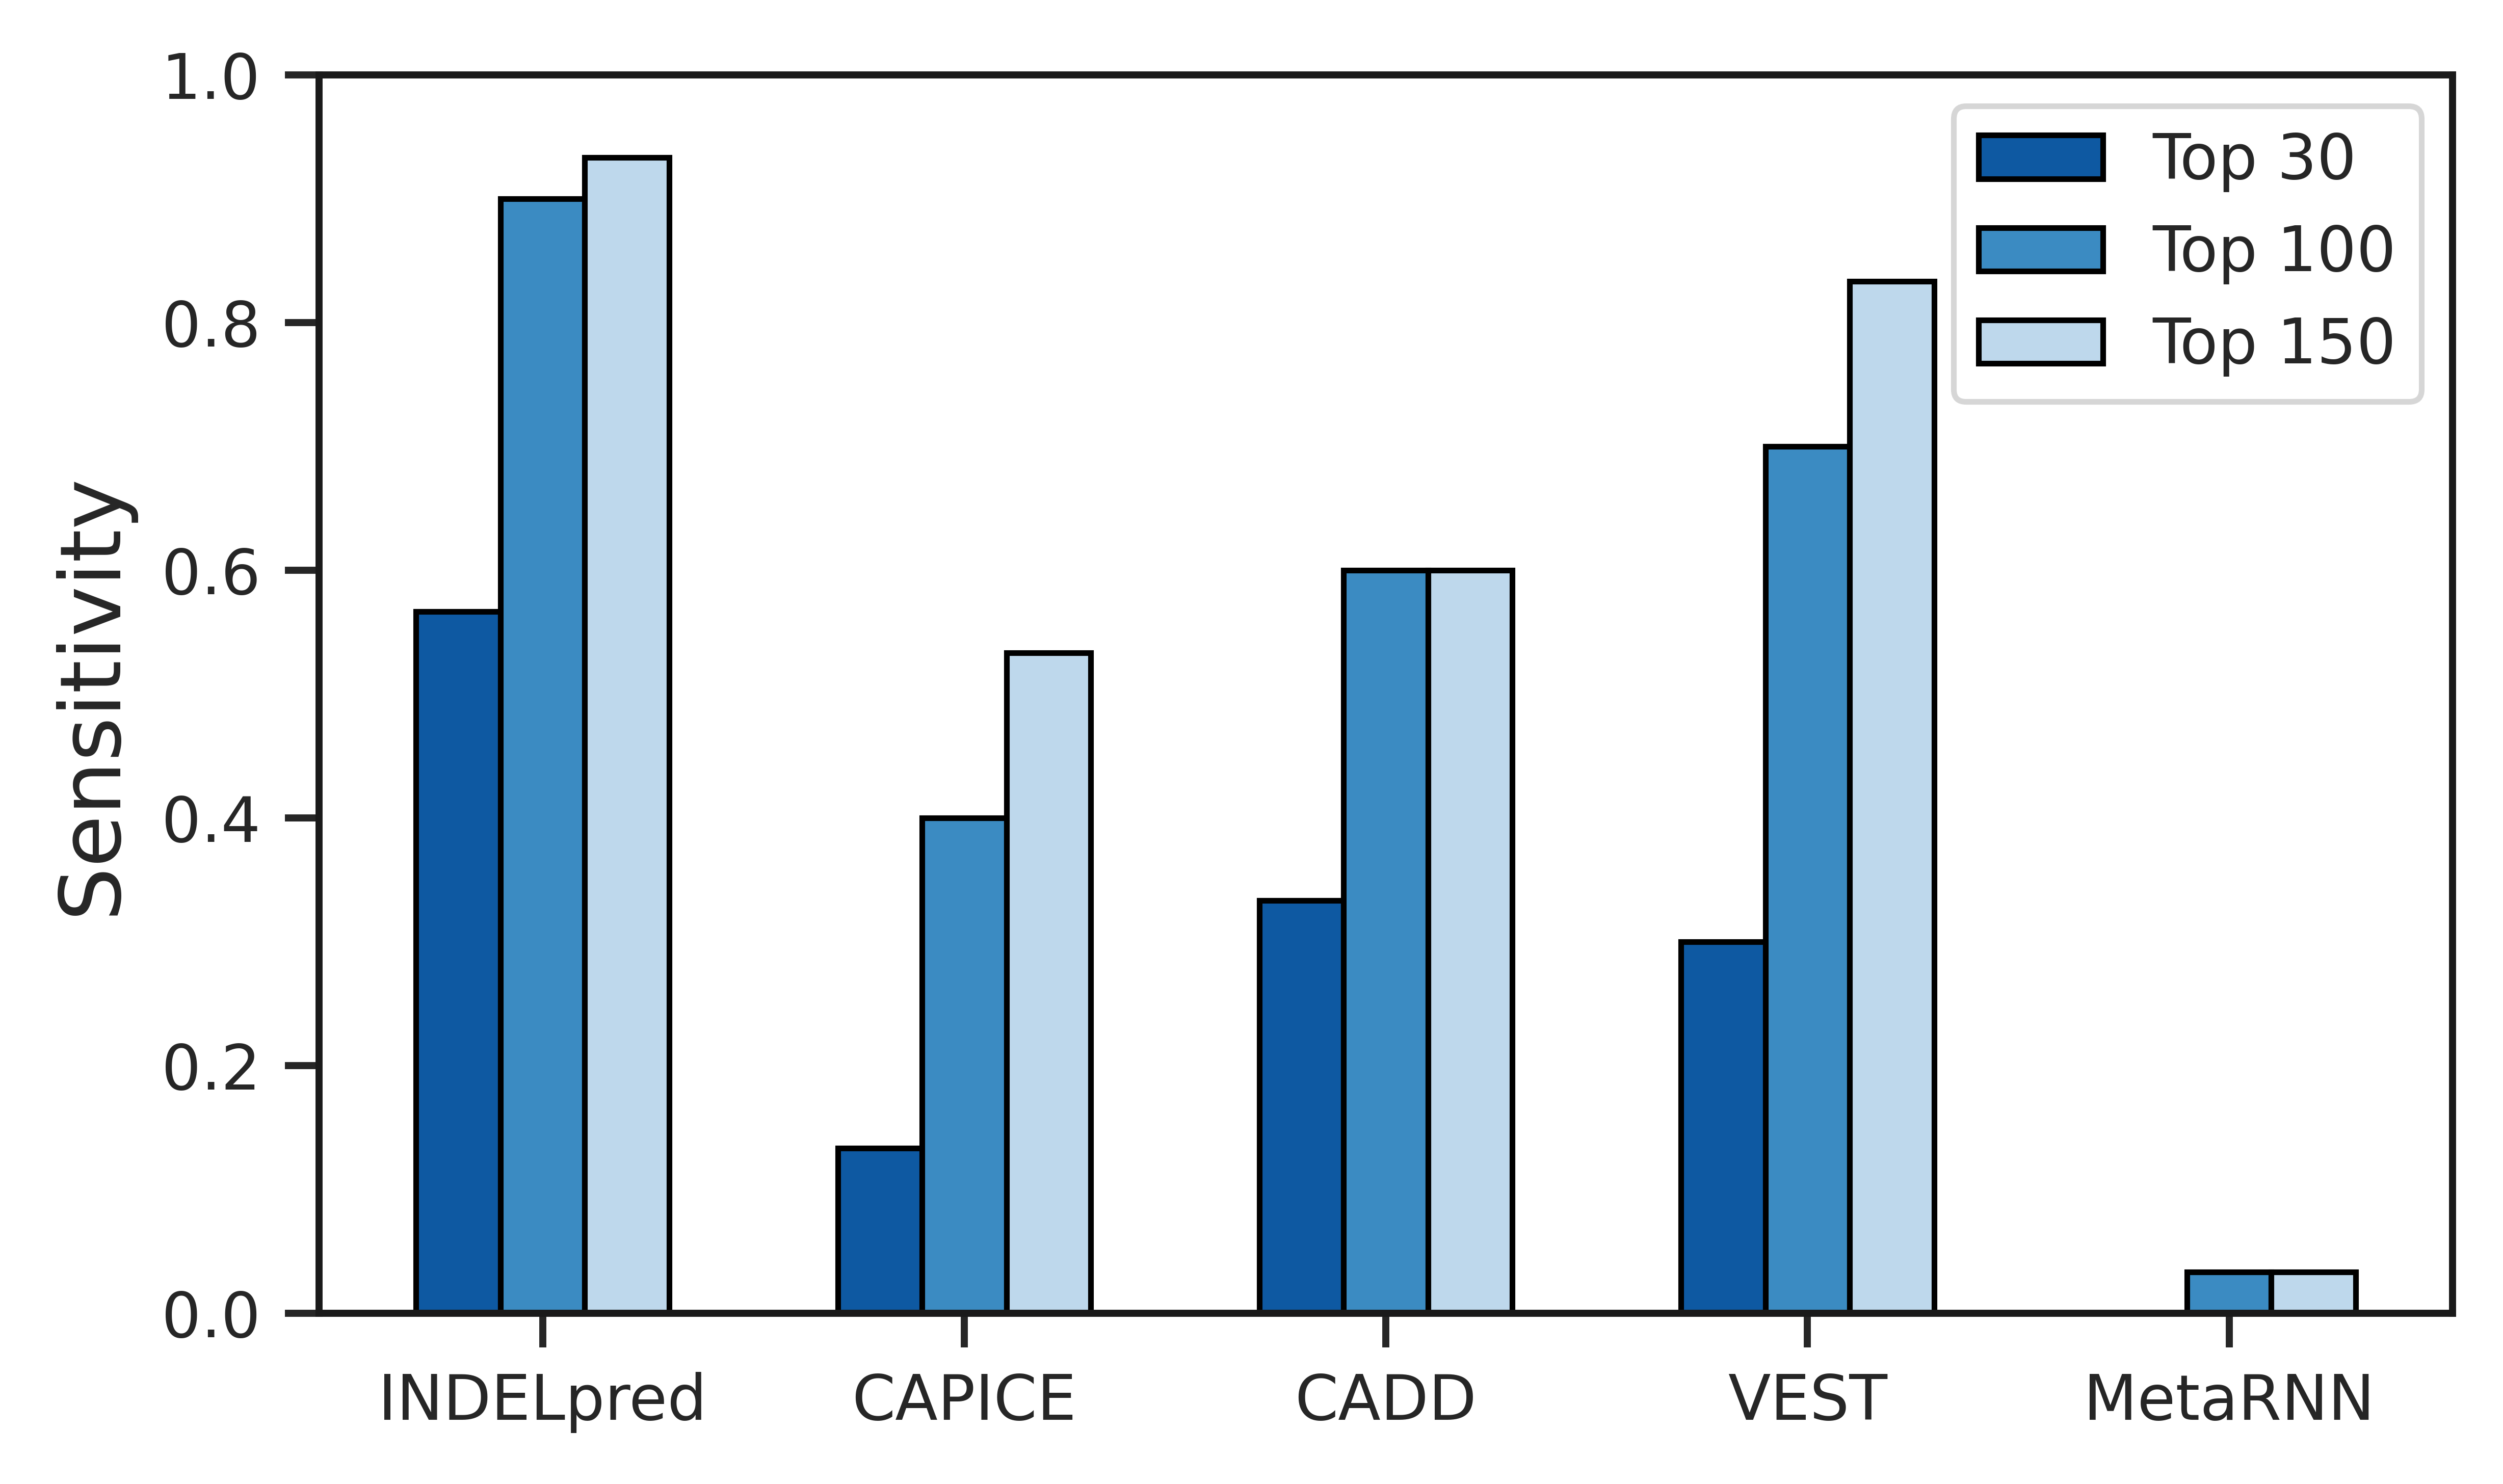

In [15]:
# Plot settings
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(5, 3))
positions = list(range(len(labels)))

bars_30 = plt.bar([p - 0.2 for p in positions], counts_30, width=0.2, color='#0E59A2', edgecolor='black', label='Top 30')
bars_100 = plt.bar(positions, counts_100, width=0.2, color='#3B8BC2', edgecolor='black', label='Top 100')
bars_150 = plt.bar([p + 0.2 for p in positions], counts_150, width=0.2, color='#BED8EC', edgecolor='black', label='Top 150')

plt.ylabel('Sensitivity', fontsize=12)
plt.ylim(0, 1)
labels = ['INDELpred', 'CAPICE', 'CADD', 'VEST', 'MetaRNN']
plt.xticks(positions, labels)

plt.legend()
plt.tight_layout()
plt.savefig(f"../final_fig/real_world_top_counts_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()

In [6]:
CADD['PHRED_scaled'] = (CADD['PHRED'] / 20) * 0.5

# 获取缩放值的最大值和最小值
min_value = CADD['PHRED_scaled'].min()
max_value = CADD['PHRED_scaled'].max()

# 归一化
CADD['PHRED_normalized'] = (CADD['PHRED_scaled'] - min_value) / (max_value - min_value)


In [7]:
methods = [(INDELpred.loc[:, 'tag'], INDELpred.loc[:, 'INDELpred score'], 0.5, 'INDELpred'),
            (CAPICE.loc[:, 'tag'], CAPICE.loc[:, 'score'], 0.5, 'CAPICE'),
            # (CADD.loc[:, 'tag'], CADD.loc[:, 'PHRED'], 20, 'CADD'),
           (CADD.loc[:, 'tag'], CADD.loc[:, 'PHRED_normalized'], 0.5, 'CADD'),
            (VEST.loc[:, 'tag'], VEST.loc[:, 'VEST score'], 0.5, 'VEST'),
            (MetaRNN.loc[:, 'tag'], MetaRNN.loc[:, 'MetaRNN-indel_score'], 0.5, 'MetaRNN')]

In [8]:
# 初始化结果存储
results = {method_name: [] for _, _, _, method_name in methods}
total_positive = 26  # 阳性的总数

# 为每个方法预先排序数据
sorted_dfs = {}
for tags, scores, threshold, method_name in methods:
    score_column = scores.name  # 获取得分列的列名
    temp_df = pd.DataFrame({'tag': tags, score_column: scores})
    sorted_dfs[method_name] = temp_df.sort_values(by=[score_column, 'tag'], ascending=[False, False])

# 为每个k值和每个方法计算敏感性
for k in range(1, 501):
    for tags, scores, threshold, method_name in methods:
        score_column = scores.name
        count = sorted_dfs[method_name].iloc[:k]['tag'].value_counts().get(1, 0)
        results[method_name].append(count / total_positive)

# 绘制结果
plt.figure(figsize=(4, 4))
for method_name, sensitivities in results.items():
    plt.plot(range(1, 501), sensitivities, label=method_name)

plt.xlabel("Top-k predictions")
plt.ylabel("Sensitivity")
plt.ylim(0, 1)
plt.legend()
plt.savefig(f"../final_fig/real_world_topk_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()



In [14]:
results['INDELpred'][100:150]

[0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230

In [10]:
# 从提供的methods列表中获取数据
data_list = [{'method': method[3], 'score': score}
             for method in methods
             for score in method[1][method[0] == 1]]

# 转化为Pandas DataFrame
df = pd.DataFrame(data_list)

# 更新score列为数值类型
df['score'] = pd.to_numeric(df['score'], errors='coerce')


In [13]:
df.groupby('method')['score'].median()

method
CADD         0.888886
CAPICE       0.994206
INDELpred    0.996582
MetaRNN      0.558510
VEST         0.875000
Name: score, dtype: float64

/jdfssz1/ST_HEALTH/P20Z10200N0041/Weiyilin/software/mambaforge/envs/sc/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jdfssz1/ST_HEALTH/P20Z10200N0041/Weiyilin/software/mambaforge/envs/sc/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


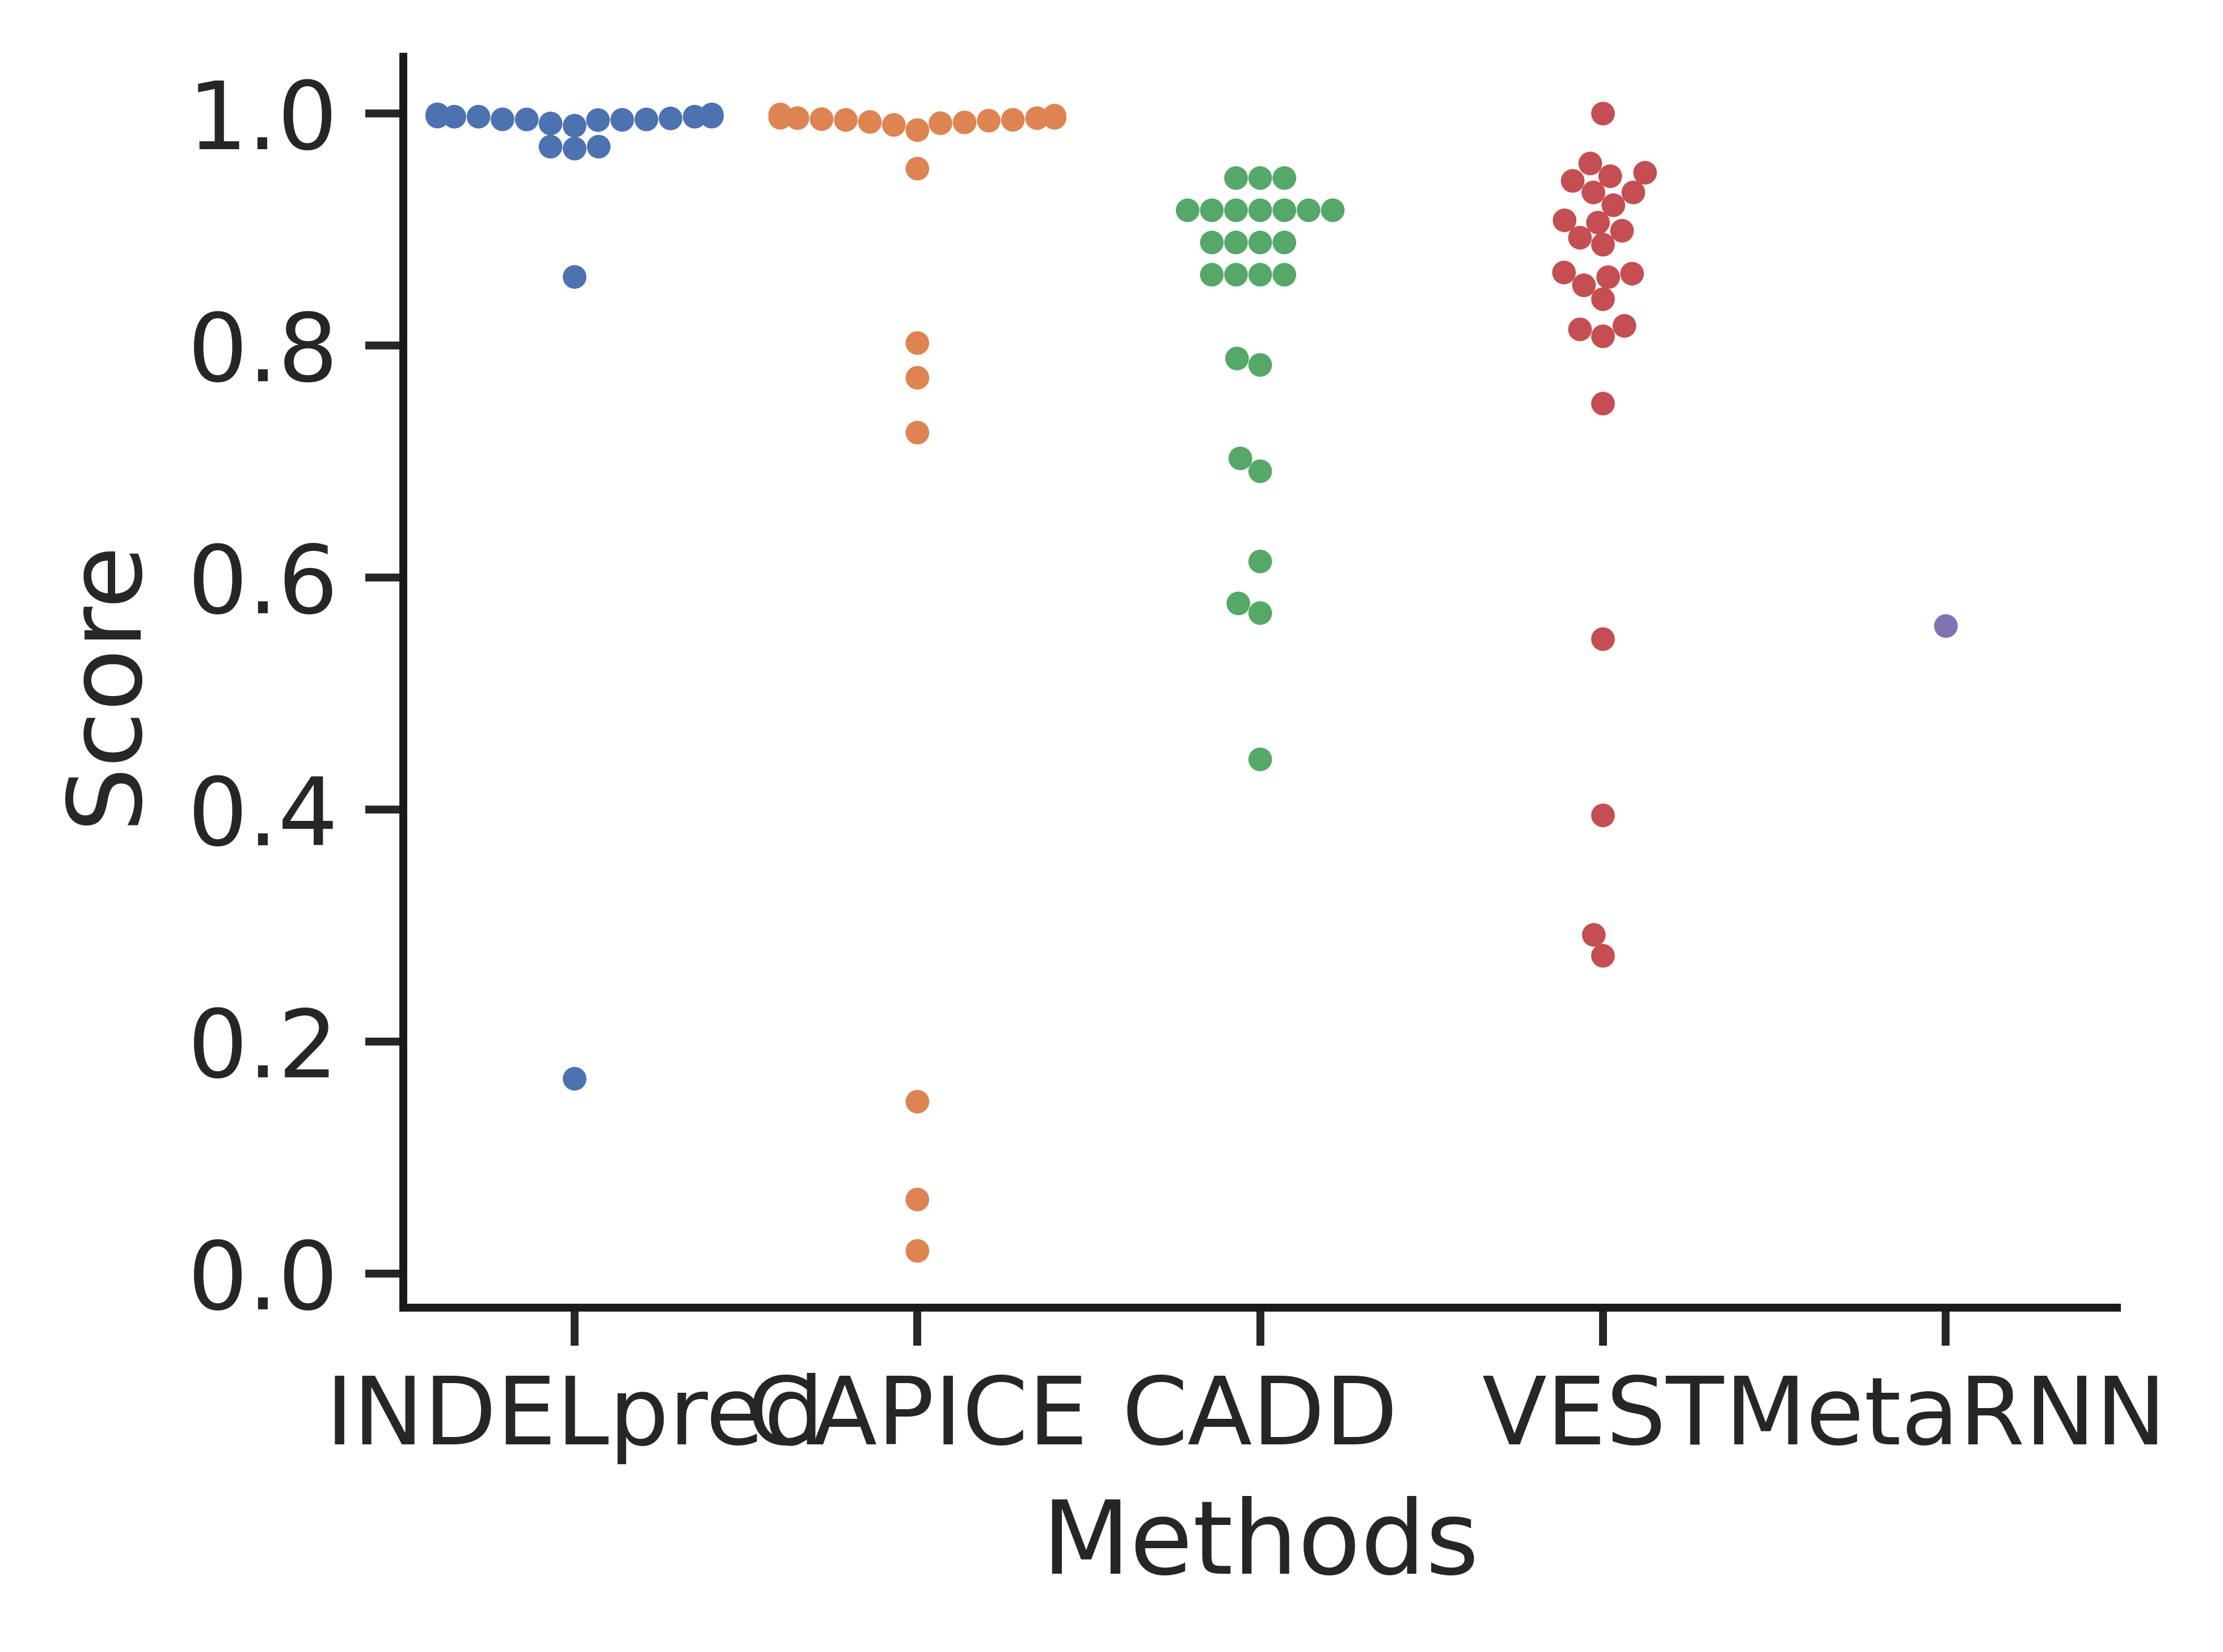

In [12]:
# 从提供的methods列表中获取数据
data_list = [{'method': method[3], 'score': score}
             for method in methods
             for score in method[1][method[0] == 1]]

# 转化为Pandas DataFrame
df = pd.DataFrame(data_list)

# 更新score列为数值类型
df['score'] = pd.to_numeric(df['score'], errors='coerce')

# 绘制图形
plt.figure(figsize=(4, 3))
# sns.boxplot(x='method', y='score', data=df, width=0.6)
sns.swarmplot(x='method', y='score', data=df, size=3, linewidth=0)

# Set title and labels
plt.xlabel('Methods', fontsize=13)
plt.ylabel('Score', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine() 

plt.tight_layout()
plt.savefig(f"../final_fig/real_world_distribution_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()


In [90]:
datasets = ["ClinVar", "VKGL", "HGMD"]

# 结果存储字典
percentile_90_values = {}

for dataset in datasets:
    # 从当前数据集中筛选tag为1的行
    filtered_data = data[dataset]["INDELpred"][data[dataset]["INDELpred"]["tag"] == 1]
    
    # 获取'INDELpred score'的第90%的数值
    percentile_90_value = filtered_data['INDELpred score'].quantile(0.1)
    
    # 将结果存储到字典中
    percentile_90_values[dataset] = percentile_90_value

# 输出结果
for dataset, value in percentile_90_values.items():
    print(f"{dataset} dataset's 90th percentile value for 'INDELpred score': {value}")


ClinVar dataset's 90th percentile value for 'INDELpred score': 0.9434156633605068
VKGL dataset's 90th percentile value for 'INDELpred score': 0.8978512382313173
HGMD dataset's 90th percentile value for 'INDELpred score': 0.8978512382313173


# 比较预测所得位点数量

In [21]:
data['VKGL']['INDELpred'].columns

Index(['CHR', 'POS', 'REF', 'ALT', 'Func.refGene', 'Gene.refGene',
       'ExonicFunc.refGene', 'AF', 'length', 'exonic', 'stream', 'intergenic',
       'intronic', 'ncRNA', 'splicing', 'UTR', 'frameshift_deletion',
       'frameshift_insertion', 'nonframeshift_deletion',
       'nonframeshift_insertion', 'startloss', 'stopgain', 'stoploss',
       'Func_b', 'Func_p', 'ExonicFunc_b', 'ExonicFunc_p', 'tag', 'star',
       'INDELpred score'],
      dtype='object')

In [12]:
dataset = "VKGL"
INDELpred = data[dataset]['INDELpred']
CAPICE = data[dataset]['CAPICE']
CADD = data[dataset]['CADD']
VEST = data[dataset]['VEST']
MetaRNN = data[dataset]['MetaRNN']
        
methods = [(INDELpred.loc[:, 'tag'], INDELpred.loc[:, 'INDELpred score'], 0.5, 'INDELpred'),
            (CAPICE.loc[:, 'tag'], CAPICE.loc[:, 'score'], 0.5, 'CAPICE'),
            (CADD.loc[:, 'tag'], CADD.loc[:, 'PHRED'], 20, 'CADD'),
            (VEST.loc[:, 'tag'], VEST.loc[:, 'VEST score'], 0.5, 'VEST'),
            (MetaRNN.loc[:, 'tag'], MetaRNN.loc[:, 'MetaRNN-indel_score'], 0.5, 'MetaRNN')]

In [13]:
MetaRNN = MetaRNN[['CHR', 'POS', 'REF', 'ALT', 'MetaRNN-indel_score']]
CADD = CADD[['CHR', 'POS', 'REF', 'ALT', 'PHRED']]
VEST = VEST[['CHR', 'POS', 'REF', 'ALT', 'VEST score']]
CAPICE = CAPICE[['CHR', 'POS', 'REF', 'ALT', 'score']]
# INDELpred = INDELpred[['CHR', 'POS', 'REF', 'ALT', 'tag', 'star', 'TumorGeneType', 'SameGene', 'Func.refGene', 'ExonicFunc.refGene', 'AF', 'length', 'INDELpred score']]
INDELpred = INDELpred[['CHR', 'POS', 'REF', 'ALT', 'tag', 'INDELpred score']]
# INDELpred = INDELpred[['CHR', 'POS', 'REF', 'ALT', 'tag', 'star', 'INDELpred score']]

In [14]:
# 使用左连接合并数据集
merged_data = INDELpred.merge(MetaRNN, on=['CHR', 'POS', 'REF', 'ALT'], how='left')
merged_data = merged_data.merge(CADD, on=['CHR', 'POS', 'REF', 'ALT'], how='left')
merged_data = merged_data.merge(VEST, on=['CHR', 'POS', 'REF', 'ALT'], how='left')
merged_data = merged_data.merge(CAPICE, on=['CHR', 'POS', 'REF', 'ALT'], how='left')
merged_data = merged_data.drop_duplicates(subset=['CHR', 'POS', 'REF', 'ALT'])

In [15]:
column_mapping = {
    'INDELpred score': 'INDELpred',
    'MetaRNN-indel_score': 'MetaRNN',
    'PHRED': 'CADD',
    'VEST score': 'VEST',
    'score': 'CAPICE'
}
merged_data.rename(columns=column_mapping, inplace=True)
merged_data[['tag', 'INDELpred', 'CAPICE', 'CADD', 'VEST', 'MetaRNN']] = merged_data[['tag', 'INDELpred', 'CAPICE', 'CADD', 'VEST', 'MetaRNN']].astype(float)

In [12]:
merged_data.to_csv(f"../final_intermediate_file/{dataset}_all_dataset_{loca}.csv", index=None)

In [17]:
score_data = merged_data[['tag', 'INDELpred', 'CAPICE', 'CADD', 'VEST', 'MetaRNN']]
def transform_column(col, threshold):
    return col.where(col.isna(), (col > threshold).astype(int))

cols_05 = ['INDELpred', 'MetaRNN', 'VEST', 'CAPICE']
for col in cols_05:
    score_data[col] = transform_column(score_data[col], 0.5)
score_data['CADD'] = transform_column(score_data['CADD'], 20)

# 统计每一列1和0的数量
counts = score_data.apply(lambda col: col.value_counts()).T
max_count = score_data.shape[0]

# 添加不足的灰色部分
counts['None'] = max_count - counts.sum(axis=1)
counts

/tmp/ipykernel_34521/2350509322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_data[col] = transform_column(score_data[col], 0.5)
/tmp/ipykernel_34521/2350509322.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_data['CADD'] = transform_column(score_data['CADD'], 20)


,0.0,1.0,None
tag,3961,3992,0
INDELpred,3559,4394,0
CAPICE,3937,4016,0
CADD,3689,4264,0
VEST,1320,3620,3013
MetaRNN,505,149,7299


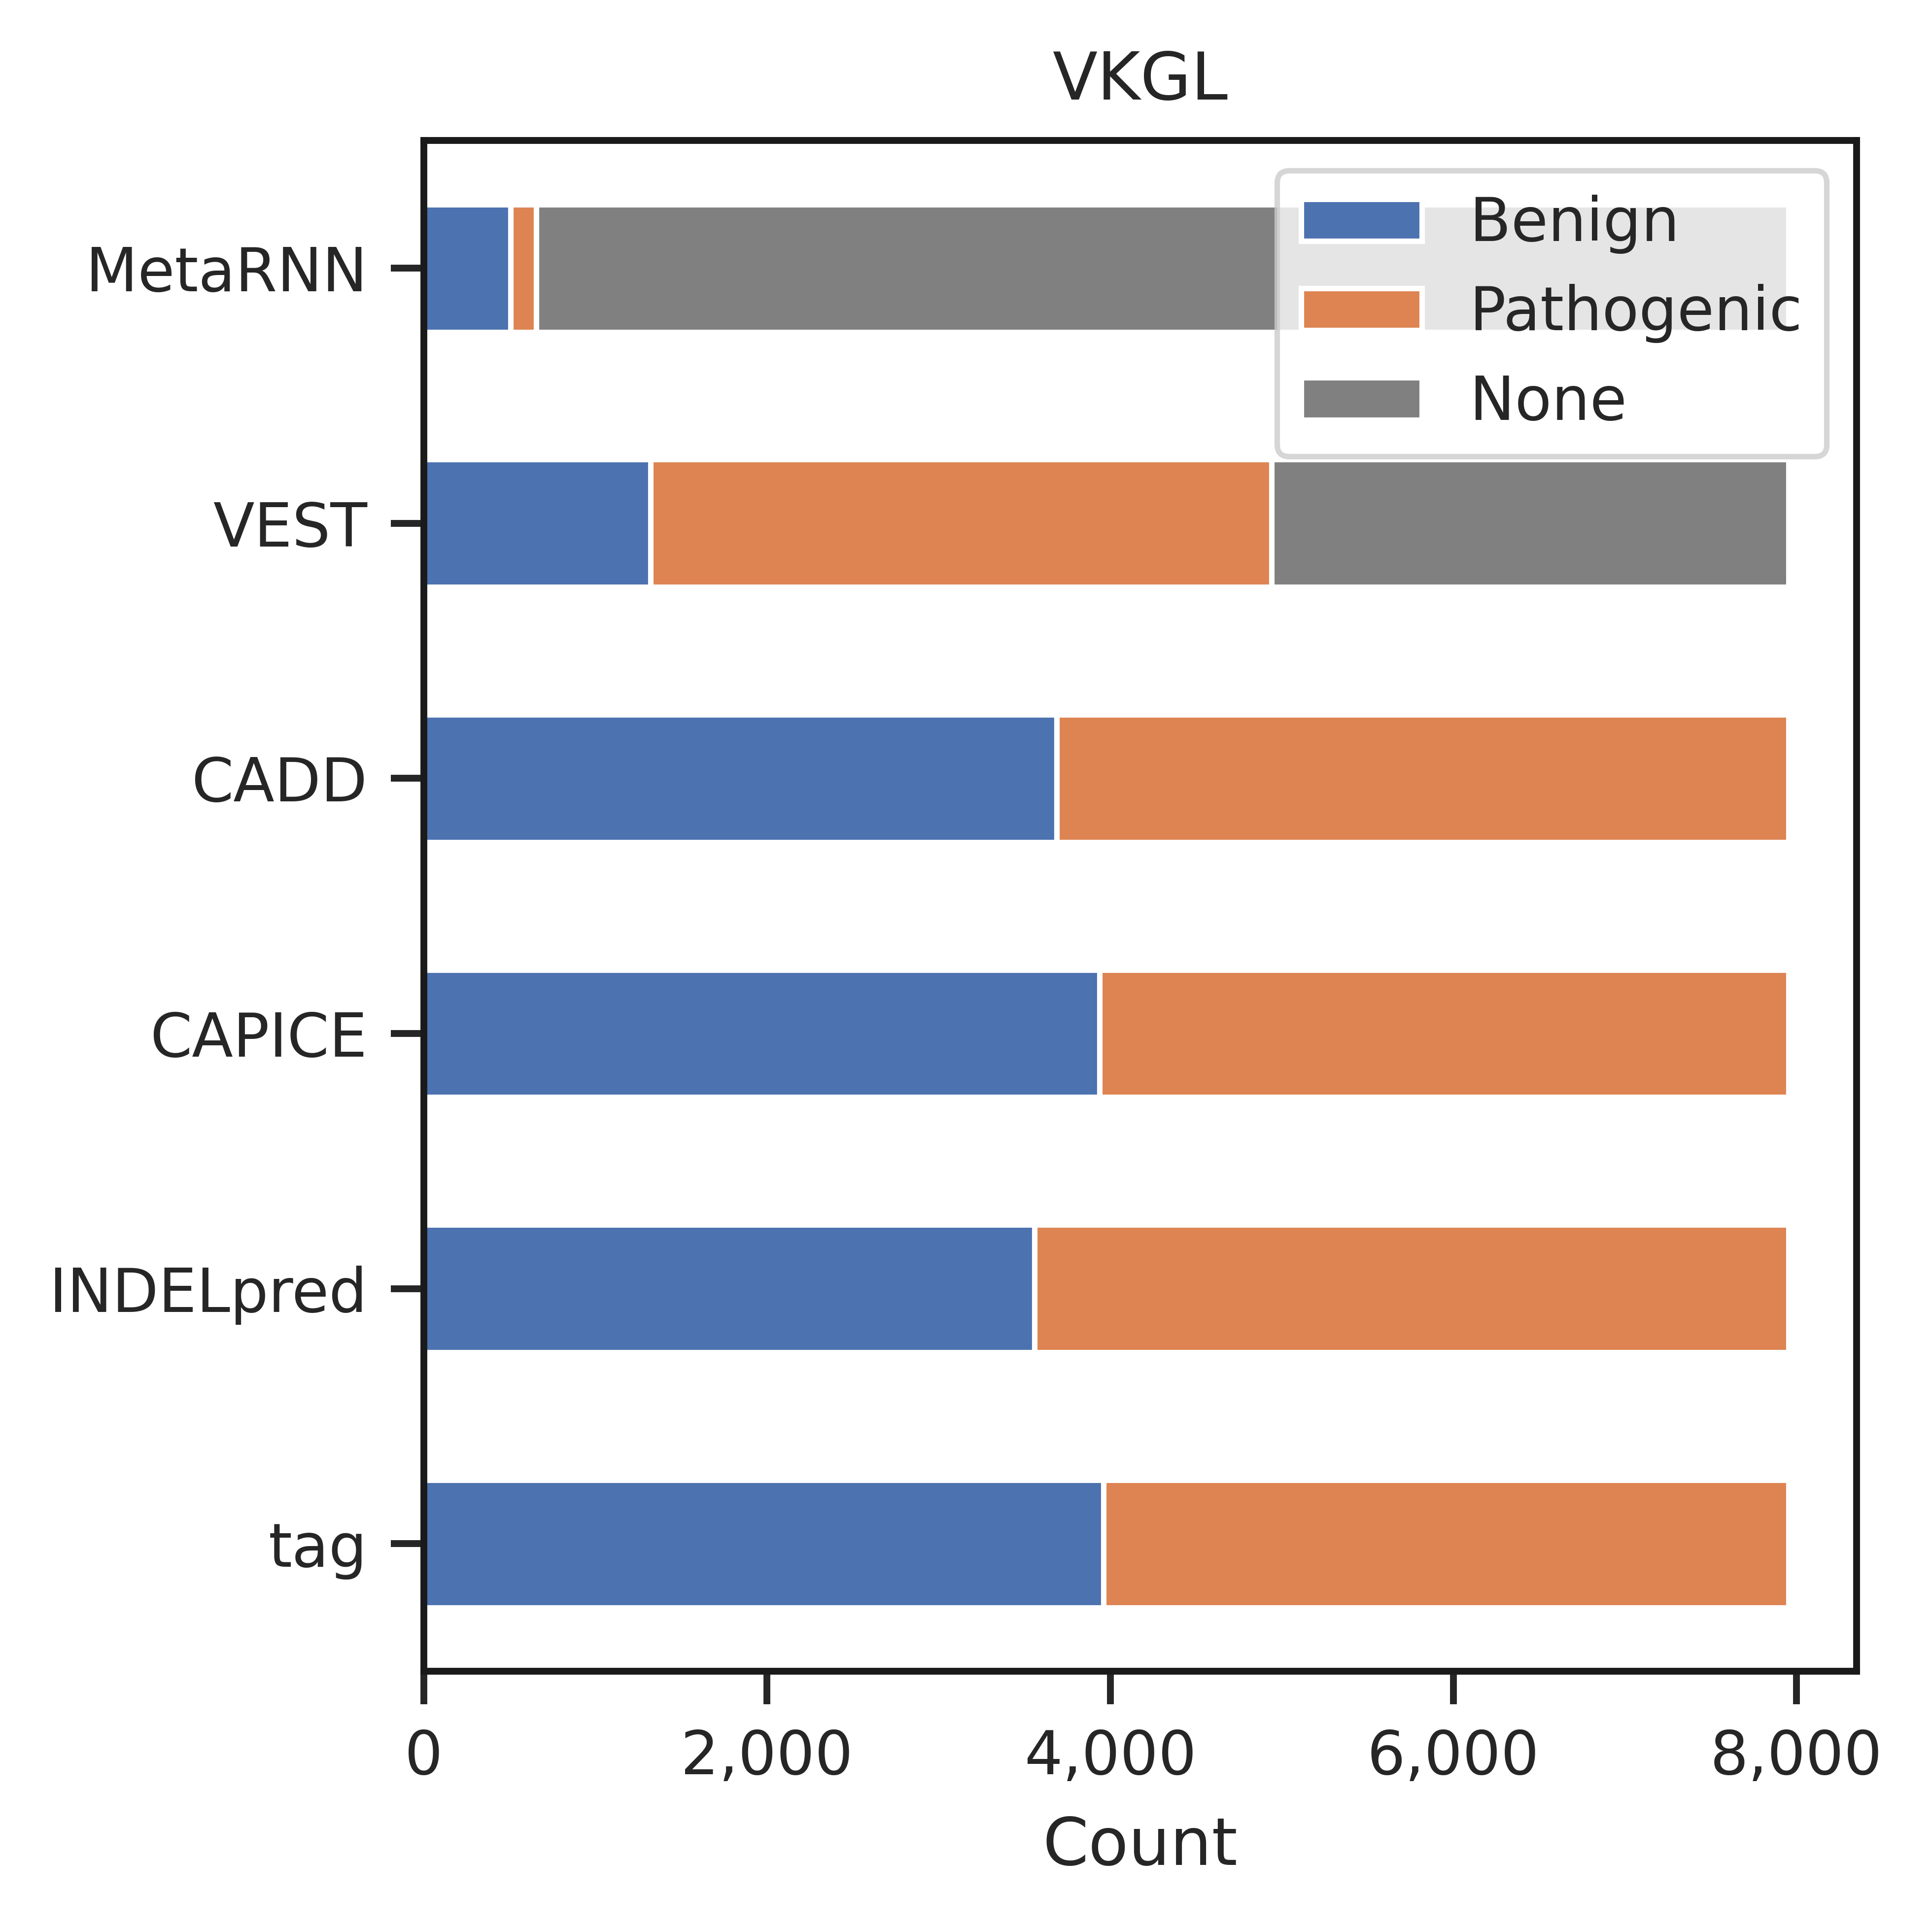

In [18]:
# 画图
fig, ax = plt.subplots(figsize=(4, 4))
default_palette = sns.color_palette()

colors = [default_palette[0], default_palette[1], 'gray']
counts[[0, 1, 'None']].plot(kind='barh', stacked=True, color=colors, ax=ax)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set_xlabel('Count')
ax.set_title(f'{dataset}')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Benign', 'Pathogenic', 'None'])
plt.tight_layout()
plt.savefig(f"../final_fig/{dataset}_score_counts_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()